### Data Dictionary


    year = the year the song was released
    songtitle = the title of the song
    artistname = the name of the artist of the song
    songID and artistID = identifying variables for the song and artist
    timesignature and timesignature_confidence = a variable estimating the time signature of the song, and the confidence in the estimate
    loudness = a continuous variable indicating the average amplitude of the audio in decibels
    tempo and tempo_confidence = a variable indicating the estimated beats per minute of the song, and the confidence in the estimate
    key and key_confidence = a variable with twelve levels indicating the estimated key of the song (C, C#, . . ., B), and the confidence in the estimate
    energy = a variable that represents the overall acoustic energy of the song, using a mix of features such as loudness
    pitch = a continuous variable that indicates the pitch of the song
    timbre_0_min, timbre_0_max, timbre_1_min, timbre_1_max, . . . , timbre_11_min, and timbre_11_max = variables that indicate the minimum/maximum values over all segments for each of the twelve values in the timbre vector (resulting in 24 continuous variables)
    Top10 = a binary variable indicating whether or not the song made it to the Top 10 of the Billboard Hot 100 Chart (1 if it was in the top 10, and 0 if it was not)


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import _hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingRegressor

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score

import keras
from keras.models import save_model, Sequential
from keras.layers import Activation, BatchNormalization, Dense
from keras.optimizers import Adam

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("songs.csv",encoding='ISO-8859-1')

In [3]:
df

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2010,This Is the House That Doubt Built,A Day to Remember,SOBGGAB12C5664F054,AROBSHL1187B9AFB01,3,0.853,-4.262,91.525,0.953,11,0.453,0.966656,0.024,0.002,57.342,-6.496,171.093,-81.664,95.117,-285.049,259.426,-40.385,73.630,-104.683,183.089,-88.771,73.549,-71.127,82.475,-52.025,39.116,-35.368,71.642,-126.440,18.658,-44.770,25.989,0
1,2010,Sticks & Bricks,A Day to Remember,SOPAQHU1315CD47F31,AROBSHL1187B9AFB01,4,1.000,-4.051,140.048,0.921,10,0.469,0.984710,0.025,0.000,57.414,-37.351,171.130,-149.589,180.334,-380.143,384.166,-48.662,100.414,-87.267,42.798,-86.895,75.455,-65.807,106.918,-61.320,35.378,-81.928,74.574,-103.808,121.935,-38.892,22.513,0
2,2010,All I Want,A Day to Remember,SOOIZOU1376E7C6386,AROBSHL1187B9AFB01,4,1.000,-3.571,160.512,0.489,2,0.209,0.989900,0.026,0.003,57.422,-17.222,171.060,-72.912,157.925,-203.984,251.258,-66.044,152.095,-98.673,141.365,-88.874,66.504,-67.433,80.621,-59.773,45.979,-46.293,59.904,-108.313,33.300,-43.733,25.744,0
3,2010,It's Complicated,A Day to Remember,SODRYWD1315CD49DBE,AROBSHL1187B9AFB01,4,1.000,-3.815,97.525,0.794,1,0.632,0.939207,0.013,0.000,57.765,-32.083,220.895,-138.596,173.365,-73.490,373.492,-55.607,119.158,-77.515,141.178,-70.790,64.540,-63.667,96.675,-78.660,41.088,-49.194,95.440,-102.676,46.422,-59.439,37.082,0
4,2010,2nd Sucks,A Day to Remember,SOICMQB1315CD46EE3,AROBSHL1187B9AFB01,4,0.788,-4.707,140.053,0.286,6,0.483,0.987738,0.063,0.000,56.872,-223.922,171.130,-147.153,166.008,-128.082,389.419,-43.908,99.332,-96.147,38.303,-110.757,72.391,-55.935,110.332,-56.450,37.555,-48.588,67.570,-52.796,22.888,-50.414,32.758,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7569,1990,She's Gone,Y&T,SOSIEQB12A6D4FC59D,ARGQANQ11F50C4769E,4,1.000,-10.197,93.140,0.859,5,0.889,0.942992,0.016,0.000,53.462,-22.878,202.424,-77.467,174.663,-170.802,201.677,-45.807,109.383,-75.011,103.305,-130.215,59.775,-61.197,38.120,-66.638,50.105,-40.692,43.763,-59.707,49.414,-53.970,68.303,0
7570,1990,Let It Out,Y&T,SOIGIQI12A6D4FC59E,ARGQANQ11F50C4769E,4,1.000,-12.392,79.858,0.196,9,0.149,0.812422,0.012,0.000,51.354,-91.916,202.639,-76.736,165.643,-186.653,166.200,-63.367,132.495,-115.231,86.509,-83.905,102.373,-66.416,83.454,-83.707,44.124,-51.628,69.929,-97.153,36.745,-61.243,56.902,0
7571,1990,Ten Lovers,Y&T,SOLNEQO12A6D4FC59F,ARGQANQ11F50C4769E,4,0.984,-10.304,91.760,0.592,2,0.077,0.736871,0.016,0.000,53.358,-10.087,202.877,-48.768,194.665,-201.008,132.174,-55.916,129.674,-82.989,166.003,-83.246,62.951,-69.512,103.413,-101.464,36.152,-45.387,48.352,-57.103,67.641,-53.729,65.176,0
7572,1990,Goin' Off The Deep End,Y&T,SOEMJEP12A58A7E7B5,ARGQANQ11F50C4769E,4,0.907,-9.295,110.907,0.838,9,0.621,0.990053,0.061,0.000,52.928,-15.289,175.845,-119.044,164.155,-162.944,391.622,-42.728,137.159,-80.171,92.551,-64.419,74.428,-38.794,108.688,-55.893,42.222,-76.631,68.336,-83.284,56.476,-51.687,59.427,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7574 entries, 0 to 7573
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      7574 non-null   int64  
 1   songtitle                 7574 non-null   object 
 2   artistname                7574 non-null   object 
 3   songID                    7574 non-null   object 
 4   artistID                  7574 non-null   object 
 5   timesignature             7574 non-null   int64  
 6   timesignature_confidence  7574 non-null   float64
 7   loudness                  7574 non-null   float64
 8   tempo                     7574 non-null   float64
 9   tempo_confidence          7574 non-null   float64
 10  key                       7574 non-null   int64  
 11  key_confidence            7574 non-null   float64
 12  energy                    7574 non-null   float64
 13  pitch                     7574 non-null   float64
 14  timbre_0

In [5]:
df.describe(include='all')

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
count,7574.000000,7574,7574,7574,7574,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000,7574.000000
unique,NaN,7141,1032,7549,1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Intro,Various artists,SODFRLK13134387FB5,ARAGWS81187FB3F768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,15,162,2,222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2001.455902,NaN,NaN,NaN,NaN,3.893979,0.853307,-8.817262,107.348267,0.622866,5.384605,0.433843,0.675471,0.010817,4.122762,54.461920,-110.785379,212.342265,-136.885915,136.672989,-186.107349,211.813801,-65.281655,108.227392,-103.997576,127.044908,-80.944168,72.166358,-84.312560,95.653221,-63.703984,50.057489,-59.515016,68.028067,-87.340055,55.520722,-50.868457,47.490774,0.147742
std,5.815223,NaN,NaN,NaN,NaN,0.532561,0.243748,4.377079,24.665030,0.304656,3.572579,0.273826,0.243473,0.013671,8.510484,3.991371,72.111815,59.923191,45.911893,49.951715,76.157411,103.769907,21.749448,33.280283,36.366486,58.555163,20.764510,20.068926,28.019622,26.859726,15.970244,14.463524,17.190527,20.381321,30.464274,23.549473,11.701530,12.463966,0.354868
min,1990.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,-42.451000,0.000000,0.000000,0.000000,0.000000,0.000020,0.000000,0.000000,12.582000,-333.718000,-74.367000,-324.858000,-0.832000,-495.358000,12.847000,-207.067000,-0.651000,-262.476000,-22.411000,-152.170000,12.697000,-214.791000,15.699000,-158.756000,-25.955000,-149.507000,8.415000,-208.819000,-6.359000,-145.599000,7.200000,0.000000
25%,1997.000000,NaN,NaN,NaN,NaN,4.000000,0.819250,-10.847000,88.860250,0.372000,2.000000,0.204000,0.500138,0.003000,0.000000,53.119500,-160.116250,171.130000,-167.641750,100.519500,-226.871250,127.137000,-77.688750,83.965500,-113.579000,84.643750,-94.792000,59.041250,-101.170750,76.498000,-73.050750,40.584500,-70.282500,53.037250,-105.130250,39.196000,-58.058000,38.975250,0.000000
50%,2002.000000,NaN,NaN,NaN,NaN,4.000000,0.979000,-7.649000,103.268000,0.701500,6.000000,0.451500,0.718160,0.007000,0.027000,55.535000,-107.750000,194.400000,-136.602000,129.908000,-170.611500,189.504000,-63.828000,107.422000,-95.467500,119.903500,-80.417500,70.467500,-81.797500,94.632500,-62.661500,49.220000,-58.650000,65.935000,-83.074000,50.895000,-50.892500,46.437500,0.000000
75%,2006.000000,NaN,NaN,NaN,NaN,4.000000,1.000000,-5.640000,124.800500,0.892000,9.000000,0.646000,0.887396,0.014000,2.771500,57.077750,-59.708250,239.242250,-106.512500,166.121250,-131.559500,290.717250,-51.344000,130.285750,-81.015250,162.338500,-66.521000,83.189750,-64.301000,112.708250,-52.982750,58.462000,-47.699750,81.267000,-64.518000,66.593000,-43.292250,55.030250,0.000000


In [6]:
df.shape

(7574, 39)

In [7]:
df.columns

Index(['year', 'songtitle', 'artistname', 'songID', 'artistID',
       'timesignature', 'timesignature_confidence', 'loudness', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max',
       'Top10'],
      dtype='object')

### Data Visualization

In [8]:
df['Top10'].value_counts()

0    6455
1    1119
Name: Top10, dtype: int64

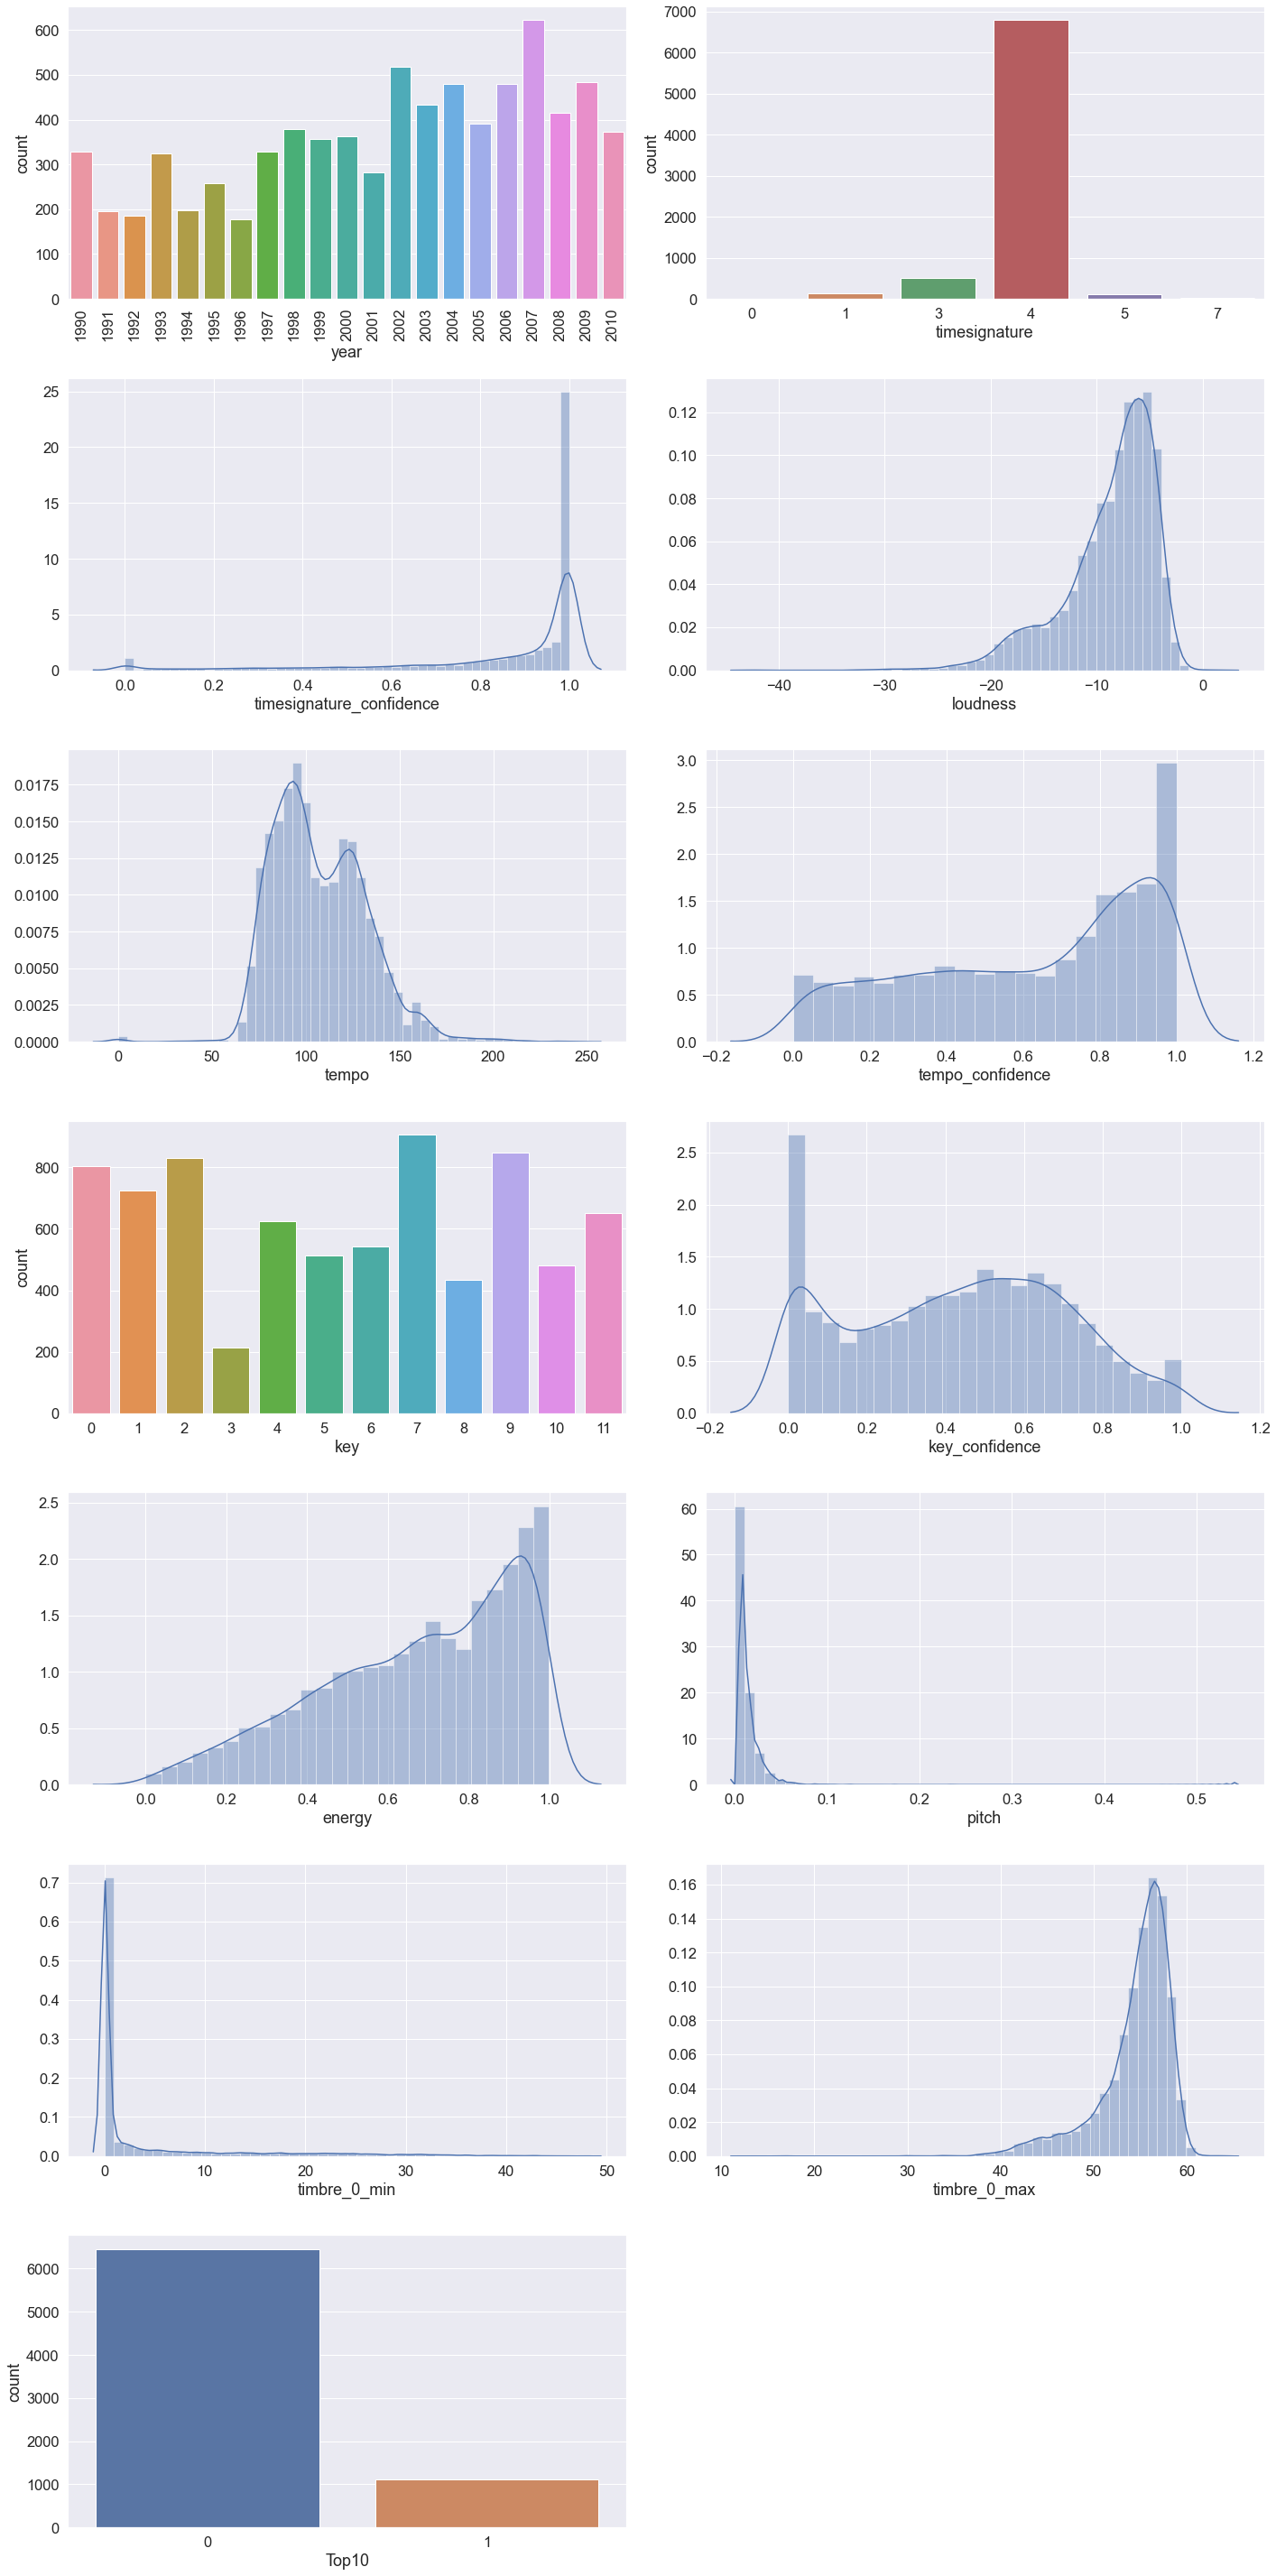

In [9]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.year)
plt.xticks(rotation=90)
plt.subplot(7,2,2)
sns.countplot(df.timesignature)
plt.subplot(7,2,3)
sns.distplot(df.timesignature_confidence)
plt.subplot(7,2,4)
sns.distplot(df.loudness)
plt.subplot(7,2,5)
sns.distplot(df.tempo)
plt.subplot(7,2,6)
sns.distplot(df.tempo_confidence)
plt.subplot(7,2,7)
sns.countplot(df.key)
plt.subplot(7,2,8)
sns.distplot(df.key_confidence)
plt.subplot(7,2,9)
sns.distplot(df.energy)
plt.subplot(7,2,10)
sns.distplot(df.pitch)
plt.subplot(7,2,11)
sns.distplot(df.timbre_0_min)
plt.subplot(7,2,12)
sns.distplot(df.timbre_0_max)
plt.subplot(7,2,13)
sns.countplot(df.Top10)
#plt.subplot(7,2,14)
#sns.distplot()

plt.tight_layout()
plt.show()

In [10]:
df.corr()

,year,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
year,1.000000,-0.007117,0.018721,0.242695,0.012650,-0.045854,-0.034196,0.002148,0.055855,-0.076973,0.076012,0.240671,-0.119949,-0.018152,0.013311,0.052150,-0.057119,0.093752,0.019889,0.055111,-0.071915,0.036581,-0.023287,0.065172,-0.124578,0.107712,-0.011822,-0.001750,-0.094134,0.094230,-0.108670,-0.008726,-0.031139,-0.064241,-0.095928
timesignature,-0.007117,1.000000,0.333240,0.106863,0.051895,0.161295,0.018242,-0.015695,0.091151,-0.093421,0.011141,0.101060,-0.014203,0.026344,-0.042254,0.018475,0.007197,-0.020722,-0.010553,0.034357,-0.051776,0.033265,-0.026346,0.053345,-0.044393,0.001009,-0.048204,0.010906,-0.014361,0.037676,-0.009577,0.018568,-0.073988,-0.005351,0.042368
timesignature_confidence,0.018721,0.333240,1.000000,0.160689,-0.031631,0.323993,0.010653,-0.016586,0.103828,-0.095404,-0.023767,0.162841,-0.024208,0.050407,-0.112440,0.001105,-0.023895,0.007255,0.019782,0.077261,-0.109739,0.055577,-0.033444,0.074470,-0.075034,0.037766,-0.079143,-0.035953,-0.052396,0.067035,-0.053067,0.025361,-0.075137,-0.035158,0.060802
loudness,0.242695,0.106863,0.160689,1.000000,0.052429,0.139639,-0.007503,0.018724,0.741992,0.060418,0.011216,0.906004,0.261835,0.050138,0.079171,0.053144,-0.020779,0.205898,-0.002771,-0.091741,-0.057961,0.069731,0.119813,-0.001722,0.095334,-0.010194,0.069963,-0.165421,0.101602,-0.020458,-0.210696,0.090838,-0.037817,-0.173830,-0.087649
tempo,0.012650,0.051895,-0.031631,0.052429,1.000000,-0.022986,0.013344,0.071195,0.155758,0.040799,0.021432,0.003306,0.076453,-0.045492,0.040717,-0.013832,0.046438,-0.003064,-0.014262,-0.082644,0.006275,-0.006791,0.076880,-0.018719,0.087368,-0.071758,0.075727,-0.017446,0.073241,-0.045644,0.025181,-0.006404,0.002953,-0.017578,-0.002545
tempo_confidence,-0.045854,0.161295,0.323993,0.139639,-0.022986,1.000000,0.016605,-0.012830,0.148477,-0.054756,-0.029657,0.075688,0.049315,0.042482,-0.131930,-0.029757,0.011262,0.033088,0.000448,0.042165,-0.105317,0.089144,-0.014231,0.061643,-0.050290,0.033832,-0.040919,-0.007301,-0.035249,0.080597,-0.042454,0.080528,-0.093434,-0.040548,0.084852
key,-0.034196,0.018242,0.010653,-0.007503,0.013344,0.016605,1.000000,-0.043337,0.009073,0.010347,-0.006804,-0.015248,0.009413,0.006847,-0.032739,0.017295,-0.007894,0.005853,-0.027782,0.005240,-0.023962,0.008617,-0.016947,0.033626,0.007678,0.004037,-0.018976,0.002632,-0.017368,0.006725,0.007107,0.012933,0.007673,0.015709,0.029125
key_confidence,0.002148,-0.015695,-0.016586,0.018724,0.071195,-0.012830,-0.043337,1.000000,-0.052697,-0.082441,-0.047067,0.059450,-0.075500,-0.038438,0.015446,-0.001692,0.001660,-0.045819,0.022001,0.026002,0.021753,-0.019601,-0.018946,-0.002130,-0.025737,-0.006882,-0.012614,0.004440,-0.021671,-0.025696,0.056118,-0.015745,-0.027153,0.035375,0.010182
energy,0.055855,0.091151,0.103828,0.741992,0.155758,0.148477,0.009073,-0.052697,1.000000,0.313516,0.091025,0.564825,0.483178,0.003715,0.237898,0.013896,0.147623,0.160646,-0.041654,-0.287470,0.032601,-0.038089,0.292606,-0.092319,0.328001,-0.172850,0.181788,-0.277573,0.316229,-0.143227,-0.110057,0.023924,0.060966,-0.242383,-0.116992
pitch,-0.076973,-0.093421,-0.095404,0.060418,0.040799,-0.054756,0.010347,-0.082441,0.313516,1.000000,0.054260,-0.044255,0.384850,-0.098849,0.347904,-0.070109,0.133702,0.035487,0.109794,-0.302149,0.224384,-0.103834,0.277396,-0.219990,0.335409,-0.182777,0.228621,-0.296569,0.286589,-0.215769,0.020565,-0.084340,0.261478,-0.203726,-0.137622


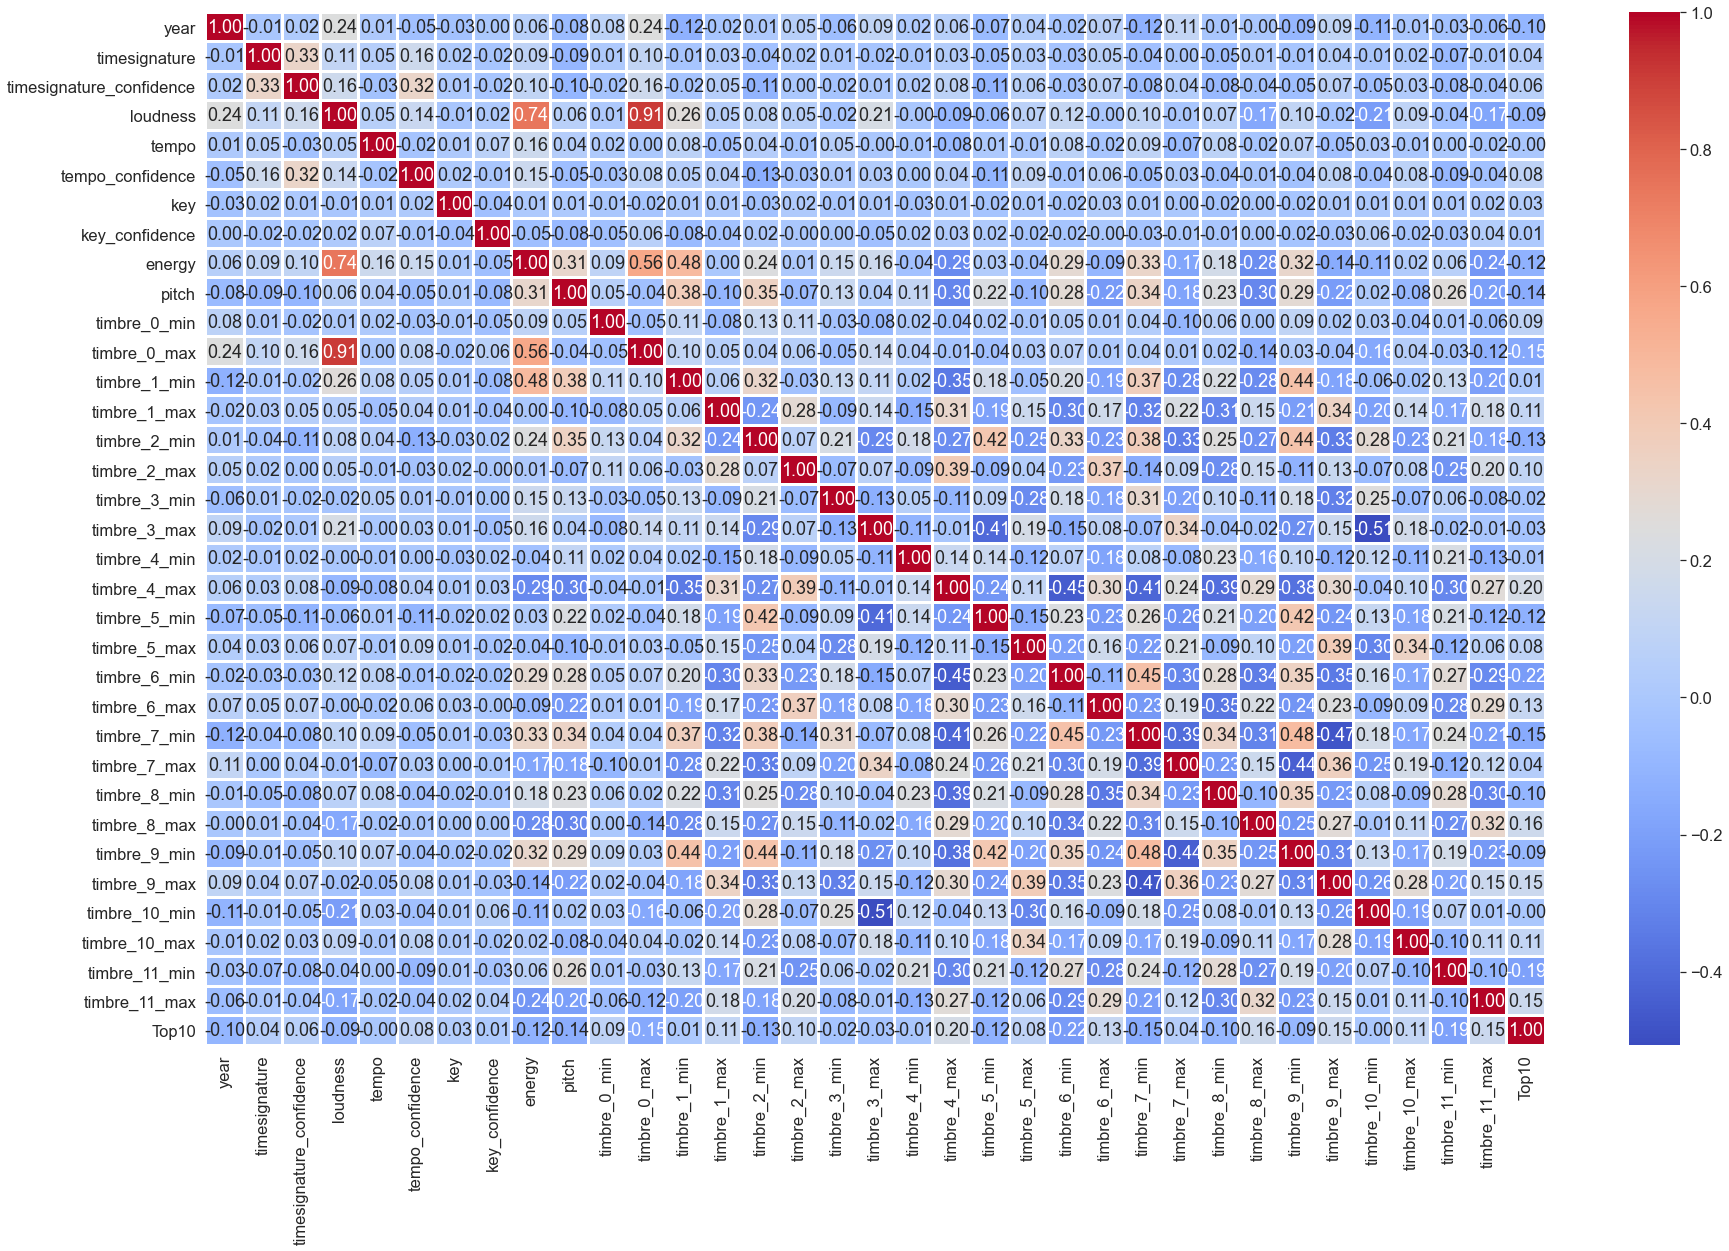

In [11]:
plt.figure(figsize=(30,19))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

In [12]:
# sns.pairplot(df.sample(500))
# plt.show()

### Data Preprocessing

### Treat Missing Values

In [13]:
df.isnull().sum()

year                        0
songtitle                   0
artistname                  0
songID                      0
artistID                    0
timesignature               0
timesignature_confidence    0
loudness                    0
tempo                       0
tempo_confidence            0
key                         0
key_confidence              0
energy                      0
pitch                       0
timbre_0_min                0
timbre_0_max                0
timbre_1_min                0
timbre_1_max                0
timbre_2_min                0
timbre_2_max                0
timbre_3_min                0
timbre_3_max                0
timbre_4_min                0
timbre_4_max                0
timbre_5_min                0
timbre_5_max                0
timbre_6_min                0
timbre_6_max                0
timbre_7_min                0
timbre_7_max                0
timbre_8_min                0
timbre_8_max                0
timbre_9_min                0
timbre_9_m

### Treat Duplicate Values

In [14]:
df.duplicated(keep='first').sum()

0

### Treat Imbalance Data

In [15]:
top10yes = df[df['Top10'] == 1]

In [16]:
top10yes

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
9,2010,Whataya Want From Me,Adam Lambert,SOFOBLL13A9E22142F,ARIGTAO11FED0C4411,4,0.938,-15.557,95.904,0.929,11,0.602,0.425909,0.004,15.599,47.851,-83.614,231.735,-125.176,192.713,-164.046,211.905,-54.926,113.781,-117.653,277.953,-80.263,76.129,-90.897,99.150,-69.346,56.233,-94.733,62.789,-102.870,65.328,-48.411,47.376,1
23,2010,We Are The World 25: For Haiti,Artists For Haiti,SOTEGEI13134389BC0,ARZAYIQ1275322AEE7,4,1.000,-6.218,75.018,0.232,4,0.709,0.711871,0.008,0.000,58.297,-175.010,171.130,-93.289,169.863,-151.942,216.772,-81.595,108.282,-84.914,144.482,-86.550,92.991,-88.239,73.640,-66.116,70.950,-50.593,55.819,-108.325,51.494,-62.202,55.321,1
24,2010,Magic,B.o.B,SOCRJPX135FFE4F1AC,ARKQQZA12086C116FC,4,1.000,-4.281,82.543,0.948,6,0.018,0.931893,0.008,0.000,57.471,-113.300,173.531,-115.426,193.923,-171.550,155.595,-75.683,109.680,-104.722,154.292,-75.857,65.525,-116.783,86.738,-66.377,45.026,-51.316,76.215,-74.426,64.825,-60.809,45.137,1
25,2010,Airplanes,B.o.B,SOVWJTF13B346C89A9,ARKQQZA12086C116FC,4,1.000,-4.632,93.041,0.943,9,0.000,0.875930,0.009,8.040,57.416,-68.910,172.242,-85.425,111.132,-189.283,319.509,-57.920,106.097,-85.214,105.962,-58.391,62.698,-101.503,109.932,-58.905,41.963,-49.356,71.626,-110.716,50.365,-44.384,29.936,1
26,2010,Nothin' On You,B.o.B,SOWHVEZ13672C4B6A4,ARKQQZA12086C116FC,4,1.000,-4.310,104.015,1.000,10,0.458,0.884820,0.007,0.000,57.936,-140.194,207.768,-74.690,141.442,-367.307,131.140,-56.402,153.979,-99.252,199.285,-90.684,71.062,-86.826,80.755,-60.000,47.343,-68.064,55.142,-97.047,50.844,-51.398,43.509,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,1990,The Way You Do The Things You Do,UB40,SOBYHAX1311AFDCA86,AR1WWVL1187B9B0306,4,1.000,-9.914,80.865,0.941,8,0.016,0.724175,0.006,12.957,53.118,-27.565,206.216,-160.510,219.216,-244.082,118.664,-71.090,125.652,-87.490,93.874,-95.402,103.980,-71.178,59.647,-45.392,78.779,-48.077,60.752,-71.797,38.005,-43.463,38.201,1
7536,1990,Ice Ice Baby,Vanilla Ice,SOJFSMW13741A466BA,ARQUN9K1187B9B5BD7,4,0.326,-9.894,115.478,0.571,7,0.702,0.683757,0.001,0.000,51.963,-173.377,276.484,-241.572,123.640,-222.758,207.571,-68.497,113.034,-121.114,147.981,-97.509,60.422,-154.418,149.028,-64.857,71.936,-96.373,87.181,-90.330,45.489,-71.101,42.939,1
7543,1990,Cherry Pie,Warrant,SOCHOMY13743D265F0,AR261YW1187FB374B3,4,0.712,-4.324,88.066,0.288,1,0.516,0.898546,0.023,0.000,58.088,-16.488,231.833,-116.554,179.146,-338.931,279.202,-62.531,115.599,-103.238,214.678,-75.943,72.145,-68.335,134.903,-82.790,53.873,-49.426,97.366,-194.978,136.589,-49.064,42.615,1
7544,1990,Release Me,Wilson Phillips,SOQNRIS13167715B05,ARY2W5X1187FB3CB7A,4,1.000,-11.634,97.217,0.914,0,0.950,0.477694,0.016,0.000,53.652,-150.628,302.599,-112.474,169.783,-186.696,120.577,-31.180,152.829,-98.220,160.532,-97.204,79.393,-99.681,116.012,-64.832,53.894,-55.841,69.711,-97.623,58.941,-52.319,65.427,1


In [17]:
top10no = df[df['Top10'] == 0]

In [18]:
top10no

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2010,This Is the House That Doubt Built,A Day to Remember,SOBGGAB12C5664F054,AROBSHL1187B9AFB01,3,0.853,-4.262,91.525,0.953,11,0.453,0.966656,0.024,0.002,57.342,-6.496,171.093,-81.664,95.117,-285.049,259.426,-40.385,73.630,-104.683,183.089,-88.771,73.549,-71.127,82.475,-52.025,39.116,-35.368,71.642,-126.440,18.658,-44.770,25.989,0
1,2010,Sticks & Bricks,A Day to Remember,SOPAQHU1315CD47F31,AROBSHL1187B9AFB01,4,1.000,-4.051,140.048,0.921,10,0.469,0.984710,0.025,0.000,57.414,-37.351,171.130,-149.589,180.334,-380.143,384.166,-48.662,100.414,-87.267,42.798,-86.895,75.455,-65.807,106.918,-61.320,35.378,-81.928,74.574,-103.808,121.935,-38.892,22.513,0
2,2010,All I Want,A Day to Remember,SOOIZOU1376E7C6386,AROBSHL1187B9AFB01,4,1.000,-3.571,160.512,0.489,2,0.209,0.989900,0.026,0.003,57.422,-17.222,171.060,-72.912,157.925,-203.984,251.258,-66.044,152.095,-98.673,141.365,-88.874,66.504,-67.433,80.621,-59.773,45.979,-46.293,59.904,-108.313,33.300,-43.733,25.744,0
3,2010,It's Complicated,A Day to Remember,SODRYWD1315CD49DBE,AROBSHL1187B9AFB01,4,1.000,-3.815,97.525,0.794,1,0.632,0.939207,0.013,0.000,57.765,-32.083,220.895,-138.596,173.365,-73.490,373.492,-55.607,119.158,-77.515,141.178,-70.790,64.540,-63.667,96.675,-78.660,41.088,-49.194,95.440,-102.676,46.422,-59.439,37.082,0
4,2010,2nd Sucks,A Day to Remember,SOICMQB1315CD46EE3,AROBSHL1187B9AFB01,4,0.788,-4.707,140.053,0.286,6,0.483,0.987738,0.063,0.000,56.872,-223.922,171.130,-147.153,166.008,-128.082,389.419,-43.908,99.332,-96.147,38.303,-110.757,72.391,-55.935,110.332,-56.450,37.555,-48.588,67.570,-52.796,22.888,-50.414,32.758,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7569,1990,She's Gone,Y&T,SOSIEQB12A6D4FC59D,ARGQANQ11F50C4769E,4,1.000,-10.197,93.140,0.859,5,0.889,0.942992,0.016,0.000,53.462,-22.878,202.424,-77.467,174.663,-170.802,201.677,-45.807,109.383,-75.011,103.305,-130.215,59.775,-61.197,38.120,-66.638,50.105,-40.692,43.763,-59.707,49.414,-53.970,68.303,0
7570,1990,Let It Out,Y&T,SOIGIQI12A6D4FC59E,ARGQANQ11F50C4769E,4,1.000,-12.392,79.858,0.196,9,0.149,0.812422,0.012,0.000,51.354,-91.916,202.639,-76.736,165.643,-186.653,166.200,-63.367,132.495,-115.231,86.509,-83.905,102.373,-66.416,83.454,-83.707,44.124,-51.628,69.929,-97.153,36.745,-61.243,56.902,0
7571,1990,Ten Lovers,Y&T,SOLNEQO12A6D4FC59F,ARGQANQ11F50C4769E,4,0.984,-10.304,91.760,0.592,2,0.077,0.736871,0.016,0.000,53.358,-10.087,202.877,-48.768,194.665,-201.008,132.174,-55.916,129.674,-82.989,166.003,-83.246,62.951,-69.512,103.413,-101.464,36.152,-45.387,48.352,-57.103,67.641,-53.729,65.176,0
7572,1990,Goin' Off The Deep End,Y&T,SOEMJEP12A58A7E7B5,ARGQANQ11F50C4769E,4,0.907,-9.295,110.907,0.838,9,0.621,0.990053,0.061,0.000,52.928,-15.289,175.845,-119.044,164.155,-162.944,391.622,-42.728,137.159,-80.171,92.551,-64.419,74.428,-38.794,108.688,-55.893,42.222,-76.631,68.336,-83.284,56.476,-51.687,59.427,0


In [19]:
top10not = top10no.sample(n=1119)

In [20]:
top10not

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
4785,2000,Beautiful War,The Gathering,SOYWKIH12AB01874CA,ARKAL321187B9AD4BE,4,0.722,-10.770,113.470,0.556,7,0.765,0.667684,0.007,0.000,52.100,-169.173,171.130,-125.675,132.957,-160.979,83.481,-43.350,70.953,-92.299,51.566,-31.544,82.943,-32.049,59.648,-63.867,52.210,-40.865,33.561,-54.793,29.500,-28.356,35.647,0
3938,2002,Clockin' G's,LL Cool J,SODZICN1315CD463D2,ARNHMFD1187FB3B3F6,4,1.000,-5.452,94.016,1.000,8,0.129,0.869200,0.003,17.135,54.358,-132.185,280.196,-169.073,48.496,-197.499,198.465,-59.875,121.498,-116.713,161.918,-106.424,89.738,-92.222,126.550,-59.952,67.814,-71.354,115.930,-102.690,58.483,-66.759,48.291,0
196,2010,This Is What We Do,Lil Scrappy,SOLIWOO13152A73A30,ARWAFY51187FB5C4EF,5,1.000,-7.771,106.685,0.435,2,0.000,0.828748,0.002,0.000,54.673,-19.348,375.226,-95.412,269.136,-116.211,129.483,-63.432,110.506,-105.375,54.299,-67.367,91.320,-44.308,74.941,-47.075,34.515,-30.988,76.652,-64.610,30.691,-56.484,56.097,0
1247,2008,Without Closure,This Is Hell,SONEBMM1312A8A7253,ARVWIEH1187B9B39B5,4,0.516,-4.367,92.923,0.306,10,0.039,0.951368,0.039,38.728,57.059,26.853,182.310,-92.703,58.371,-74.836,173.599,-46.045,31.698,-64.353,23.334,-58.239,50.155,-33.498,48.503,-44.475,19.202,-26.812,34.340,-100.010,25.076,-40.330,24.885,0
5121,1999,I'm with Stupid,Static-X,SOZZBXW137305C51FD,ARHRY5S1187B99B96F,4,1.000,-5.632,138.083,0.851,7,0.295,0.981318,0.019,2.770,55.794,-37.310,240.467,-88.291,267.886,-187.313,229.973,-58.885,126.170,-100.413,115.592,-91.750,58.077,-67.426,75.440,-74.619,32.168,-34.749,78.767,-84.572,37.982,-64.447,44.742,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,2010,Bring the Ruckus,Manafest,SOROEKC1312A8AC135,ARYZ8BG1187FB52ABB,4,1.000,-3.878,82.048,0.787,6,0.005,0.939296,0.032,28.080,57.576,-14.992,467.588,-122.543,271.717,-230.224,375.059,-60.804,99.719,-112.253,271.984,-53.722,73.604,-42.362,81.924,-59.664,39.283,-55.034,73.529,-118.846,34.482,-52.570,37.031,0
3278,2003,Radiant Eclipse,Avenged Sevenfold,SOVCZMN13B11931FAB,ARC9CR51187FB51A13,4,0.995,-6.968,125.025,0.734,5,0.065,0.898375,0.022,0.000,55.530,-109.789,202.578,-116.648,135.608,-132.293,162.535,-80.794,57.491,-97.975,164.937,-67.838,55.970,-65.214,60.342,-51.356,46.220,-38.146,69.565,-74.910,74.053,-43.551,43.114,0
5189,1999,Sterile,Vice Squad,SOBMOYV13167713F89,ARW9NPM1187B9911AF,4,0.913,-6.834,164.810,0.376,2,0.886,0.897457,0.004,0.000,54.070,-118.397,171.130,-85.120,143.307,-176.110,206.076,-52.508,133.812,-100.379,44.874,-45.940,86.547,-57.205,78.849,-27.665,45.437,-35.197,67.921,-88.275,27.289,-43.270,53.477,0
3132,2004,The Revolution Starts Now,Steve Earle,SOIVZYX137396F5E63,ARRX7Z01187B9AC449,4,1.000,-17.274,124.052,0.253,10,0.675,0.418163,0.021,1.532,43.865,-177.421,147.970,-90.676,178.430,-320.300,146.689,-99.332,69.468,-67.568,119.291,-71.769,60.354,-152.295,78.711,-57.028,49.802,-78.614,68.451,-61.749,32.594,-111.057,25.461,0


In [21]:
df2 = pd.concat([top10not,top10yes],axis=0)

In [22]:
df2

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
4785,2000,Beautiful War,The Gathering,SOYWKIH12AB01874CA,ARKAL321187B9AD4BE,4,0.722,-10.770,113.470,0.556,7,0.765,0.667684,0.007,0.000,52.100,-169.173,171.130,-125.675,132.957,-160.979,83.481,-43.350,70.953,-92.299,51.566,-31.544,82.943,-32.049,59.648,-63.867,52.210,-40.865,33.561,-54.793,29.500,-28.356,35.647,0
3938,2002,Clockin' G's,LL Cool J,SODZICN1315CD463D2,ARNHMFD1187FB3B3F6,4,1.000,-5.452,94.016,1.000,8,0.129,0.869200,0.003,17.135,54.358,-132.185,280.196,-169.073,48.496,-197.499,198.465,-59.875,121.498,-116.713,161.918,-106.424,89.738,-92.222,126.550,-59.952,67.814,-71.354,115.930,-102.690,58.483,-66.759,48.291,0
196,2010,This Is What We Do,Lil Scrappy,SOLIWOO13152A73A30,ARWAFY51187FB5C4EF,5,1.000,-7.771,106.685,0.435,2,0.000,0.828748,0.002,0.000,54.673,-19.348,375.226,-95.412,269.136,-116.211,129.483,-63.432,110.506,-105.375,54.299,-67.367,91.320,-44.308,74.941,-47.075,34.515,-30.988,76.652,-64.610,30.691,-56.484,56.097,0
1247,2008,Without Closure,This Is Hell,SONEBMM1312A8A7253,ARVWIEH1187B9B39B5,4,0.516,-4.367,92.923,0.306,10,0.039,0.951368,0.039,38.728,57.059,26.853,182.310,-92.703,58.371,-74.836,173.599,-46.045,31.698,-64.353,23.334,-58.239,50.155,-33.498,48.503,-44.475,19.202,-26.812,34.340,-100.010,25.076,-40.330,24.885,0
5121,1999,I'm with Stupid,Static-X,SOZZBXW137305C51FD,ARHRY5S1187B99B96F,4,1.000,-5.632,138.083,0.851,7,0.295,0.981318,0.019,2.770,55.794,-37.310,240.467,-88.291,267.886,-187.313,229.973,-58.885,126.170,-100.413,115.592,-91.750,58.077,-67.426,75.440,-74.619,32.168,-34.749,78.767,-84.572,37.982,-64.447,44.742,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7535,1990,The Way You Do The Things You Do,UB40,SOBYHAX1311AFDCA86,AR1WWVL1187B9B0306,4,1.000,-9.914,80.865,0.941,8,0.016,0.724175,0.006,12.957,53.118,-27.565,206.216,-160.510,219.216,-244.082,118.664,-71.090,125.652,-87.490,93.874,-95.402,103.980,-71.178,59.647,-45.392,78.779,-48.077,60.752,-71.797,38.005,-43.463,38.201,1
7536,1990,Ice Ice Baby,Vanilla Ice,SOJFSMW13741A466BA,ARQUN9K1187B9B5BD7,4,0.326,-9.894,115.478,0.571,7,0.702,0.683757,0.001,0.000,51.963,-173.377,276.484,-241.572,123.640,-222.758,207.571,-68.497,113.034,-121.114,147.981,-97.509,60.422,-154.418,149.028,-64.857,71.936,-96.373,87.181,-90.330,45.489,-71.101,42.939,1
7543,1990,Cherry Pie,Warrant,SOCHOMY13743D265F0,AR261YW1187FB374B3,4,0.712,-4.324,88.066,0.288,1,0.516,0.898546,0.023,0.000,58.088,-16.488,231.833,-116.554,179.146,-338.931,279.202,-62.531,115.599,-103.238,214.678,-75.943,72.145,-68.335,134.903,-82.790,53.873,-49.426,97.366,-194.978,136.589,-49.064,42.615,1
7544,1990,Release Me,Wilson Phillips,SOQNRIS13167715B05,ARY2W5X1187FB3CB7A,4,1.000,-11.634,97.217,0.914,0,0.950,0.477694,0.016,0.000,53.652,-150.628,302.599,-112.474,169.783,-186.696,120.577,-31.180,152.829,-98.220,160.532,-97.204,79.393,-99.681,116.012,-64.832,53.894,-55.841,69.711,-97.623,58.941,-52.319,65.427,1


In [23]:
df2['Top10'].value_counts()

1    1119
0    1119
Name: Top10, dtype: int64

In [24]:
df2.sample(frac=1)

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
6146,1995,Roll To Me,Del Amitri,SOARNOC1315CD45C68,ARD3Y081187B9ABB07,4,0.831,-5.659,75.068,0.000,6,0.194,0.827236,0.007,0.000,56.278,-201.719,171.130,-170.580,131.424,-373.646,145.964,-25.321,114.185,-94.661,106.315,-86.266,72.423,-127.613,96.432,-70.590,54.963,-45.025,85.447,-89.146,37.954,-41.929,58.949,1
1762,2007,Soul Back Driver,The Cliks,SOOGPOU131634AA1D7,ARXK6E71187FB4AA1E,3,1.000,-5.326,125.235,0.729,11,0.754,0.432855,0.010,1.288,57.897,-130.945,328.429,-150.662,178.685,-257.143,404.030,-71.994,100.250,-91.049,122.397,-84.334,72.736,-85.630,135.234,-64.612,59.530,-80.258,88.607,-98.703,57.544,-63.101,34.748,0
2219,2006,Waterproof,Sparks,SOSOKRT1377686F131,AR040JZ1187FB399A9,4,0.872,-9.766,77.008,0.256,0,0.817,0.545382,0.004,0.092,54.042,-164.628,169.334,-135.094,112.982,-186.915,258.279,-37.192,115.511,-75.462,123.356,-92.804,53.806,-60.965,108.441,-56.450,35.282,-63.028,54.733,-85.376,54.243,-42.077,40.072,0
5968,1996,Doin It,LL Cool J,SOECRZV13730F409AB,ARNHMFD1187FB3B3F6,4,1.000,-12.365,95.013,0.884,10,0.783,0.511437,0.003,0.000,50.719,-214.733,266.414,-218.043,198.199,-158.932,238.084,-68.233,128.820,-173.566,153.294,-112.641,78.240,-154.654,124.683,-57.347,83.237,-75.559,101.542,-75.383,58.692,-46.893,64.267,1
54,2010,Find Your Love,Drake,SOJSITU13A9DF07483,ARODZUF11F4C841E1F,4,1.000,-18.975,98.878,0.842,6,0.665,0.344354,0.009,11.907,44.579,-103.705,196.220,-159.121,98.662,-100.648,270.264,-46.026,133.721,-91.092,90.917,-84.225,72.589,-87.974,89.713,-64.631,53.243,-59.440,64.834,-82.026,80.115,-76.682,42.646,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6307,1995,That Was Another Country,The Innocence Mission,SONLRZB1315CD481FF,ARJC4N31187B9B2A21,4,0.993,-10.158,118.114,0.108,5,0.794,0.402010,0.003,0.000,54.247,-93.750,256.265,-208.238,88.191,-164.385,112.166,-67.973,96.294,-100.970,70.310,-85.718,80.969,-83.776,53.094,-60.520,47.794,-72.010,45.782,-78.807,39.225,-41.884,50.351,0
1122,2008,Closer,Ne-Yo,SOPWXGY13733300351,ARAWOLW1187FB3AB70,4,0.564,-6.310,158.406,0.200,4,0.629,0.716360,0.004,0.000,55.643,-179.064,216.407,-113.620,118.499,-126.564,324.918,-102.576,98.699,-194.910,115.761,-77.148,122.367,-74.411,138.451,-76.667,85.720,-79.278,68.416,-69.940,82.703,-46.045,72.051,1
5417,1998,Frozen,Madonna,SODAJBS135BF6EE9DA,ARBEOHF1187B9B044D,4,0.989,-8.452,108.009,0.489,5,0.497,0.711840,0.005,0.086,54.991,-231.616,178.405,-111.544,112.783,-136.462,108.644,-57.225,157.078,-83.247,103.142,-123.618,51.493,-95.209,82.126,-64.297,62.026,-65.233,54.164,-87.269,36.148,-54.498,53.436,1
1918,2006,A Little's Enough,Angels & Airwaves,SOWFTHD12A58A7B838,ARXQW9Z1187FB4D183,4,1.000,-7.362,139.106,0.625,9,0.431,0.745131,0.000,2.917,57.264,-182.210,243.649,-114.123,84.310,-190.029,103.597,-63.190,81.912,-72.866,142.514,-64.469,87.590,-87.152,98.195,-44.252,55.474,-81.523,77.195,-76.225,48.788,-43.721,37.079,0


In [25]:
df2.reset_index(drop=True,inplace=True)

In [26]:
df2

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2000,Beautiful War,The Gathering,SOYWKIH12AB01874CA,ARKAL321187B9AD4BE,4,0.722,-10.770,113.470,0.556,7,0.765,0.667684,0.007,0.000,52.100,-169.173,171.130,-125.675,132.957,-160.979,83.481,-43.350,70.953,-92.299,51.566,-31.544,82.943,-32.049,59.648,-63.867,52.210,-40.865,33.561,-54.793,29.500,-28.356,35.647,0
1,2002,Clockin' G's,LL Cool J,SODZICN1315CD463D2,ARNHMFD1187FB3B3F6,4,1.000,-5.452,94.016,1.000,8,0.129,0.869200,0.003,17.135,54.358,-132.185,280.196,-169.073,48.496,-197.499,198.465,-59.875,121.498,-116.713,161.918,-106.424,89.738,-92.222,126.550,-59.952,67.814,-71.354,115.930,-102.690,58.483,-66.759,48.291,0
2,2010,This Is What We Do,Lil Scrappy,SOLIWOO13152A73A30,ARWAFY51187FB5C4EF,5,1.000,-7.771,106.685,0.435,2,0.000,0.828748,0.002,0.000,54.673,-19.348,375.226,-95.412,269.136,-116.211,129.483,-63.432,110.506,-105.375,54.299,-67.367,91.320,-44.308,74.941,-47.075,34.515,-30.988,76.652,-64.610,30.691,-56.484,56.097,0
3,2008,Without Closure,This Is Hell,SONEBMM1312A8A7253,ARVWIEH1187B9B39B5,4,0.516,-4.367,92.923,0.306,10,0.039,0.951368,0.039,38.728,57.059,26.853,182.310,-92.703,58.371,-74.836,173.599,-46.045,31.698,-64.353,23.334,-58.239,50.155,-33.498,48.503,-44.475,19.202,-26.812,34.340,-100.010,25.076,-40.330,24.885,0
4,1999,I'm with Stupid,Static-X,SOZZBXW137305C51FD,ARHRY5S1187B99B96F,4,1.000,-5.632,138.083,0.851,7,0.295,0.981318,0.019,2.770,55.794,-37.310,240.467,-88.291,267.886,-187.313,229.973,-58.885,126.170,-100.413,115.592,-91.750,58.077,-67.426,75.440,-74.619,32.168,-34.749,78.767,-84.572,37.982,-64.447,44.742,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,1990,The Way You Do The Things You Do,UB40,SOBYHAX1311AFDCA86,AR1WWVL1187B9B0306,4,1.000,-9.914,80.865,0.941,8,0.016,0.724175,0.006,12.957,53.118,-27.565,206.216,-160.510,219.216,-244.082,118.664,-71.090,125.652,-87.490,93.874,-95.402,103.980,-71.178,59.647,-45.392,78.779,-48.077,60.752,-71.797,38.005,-43.463,38.201,1
2234,1990,Ice Ice Baby,Vanilla Ice,SOJFSMW13741A466BA,ARQUN9K1187B9B5BD7,4,0.326,-9.894,115.478,0.571,7,0.702,0.683757,0.001,0.000,51.963,-173.377,276.484,-241.572,123.640,-222.758,207.571,-68.497,113.034,-121.114,147.981,-97.509,60.422,-154.418,149.028,-64.857,71.936,-96.373,87.181,-90.330,45.489,-71.101,42.939,1
2235,1990,Cherry Pie,Warrant,SOCHOMY13743D265F0,AR261YW1187FB374B3,4,0.712,-4.324,88.066,0.288,1,0.516,0.898546,0.023,0.000,58.088,-16.488,231.833,-116.554,179.146,-338.931,279.202,-62.531,115.599,-103.238,214.678,-75.943,72.145,-68.335,134.903,-82.790,53.873,-49.426,97.366,-194.978,136.589,-49.064,42.615,1
2236,1990,Release Me,Wilson Phillips,SOQNRIS13167715B05,ARY2W5X1187FB3CB7A,4,1.000,-11.634,97.217,0.914,0,0.950,0.477694,0.016,0.000,53.652,-150.628,302.599,-112.474,169.783,-186.696,120.577,-31.180,152.829,-98.220,160.532,-97.204,79.393,-99.681,116.012,-64.832,53.894,-55.841,69.711,-97.623,58.941,-52.319,65.427,1


In [27]:
df2.sample(frac=1)

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
678,2006,Doornails,NOFX,SOTKGGE131343A27CC,AR06EB01187FB40150,4,0.872,-12.544,81.015,0.137,7,0.100,0.336629,0.003,1.957,51.454,-106.428,187.067,-147.324,81.941,-331.108,280.969,-62.640,80.933,-90.251,125.942,-86.977,63.742,-105.027,83.681,-83.015,25.946,-46.384,77.477,-111.476,38.799,-55.298,47.938,0
2076,1991,Everybody Plays The Fool,Aaron Neville,SOFVHLO1377B289BD8,ARCN61O1187B9ABBE8,4,1.000,-9.848,88.024,1.000,5,0.763,0.710403,0.008,0.000,53.533,-101.965,171.130,-149.523,126.119,-149.845,117.396,-86.046,135.905,-92.745,106.455,-86.822,94.940,-86.421,82.796,-73.957,40.262,-58.604,68.862,-68.151,46.767,-43.652,51.548,1
1525,2004,My Boo,Usher & Alicia Keys,SOZAQPO13D3A5D4B7B,ARRLJGE13A4B40020F,4,1.000,-8.088,86.395,0.923,7,0.412,0.489008,0.002,0.086,56.027,-67.803,263.057,-136.496,192.153,-244.127,146.609,-96.770,159.411,-103.195,134.016,-96.390,71.030,-77.350,81.074,-65.621,67.722,-59.442,87.270,-74.852,79.067,-49.949,47.890,1
1889,1996,Always Be My Baby,Mariah Carey,SOFBJWT1379E4BA48D,ARKSZW81187B9B695D,4,0.951,-18.586,157.771,0.543,6,0.264,0.234186,0.003,4.787,41.382,-118.703,180.097,-159.651,186.805,-222.170,130.566,-48.052,130.404,-66.437,166.256,-80.634,95.877,-62.985,62.556,-65.407,61.084,-54.364,62.654,-79.461,83.620,-64.888,60.493,1
946,2010,An Exercise in Humility,Analog Rebellion,SOMTUYH12AB018B8EE,ARYGZHO1271F5760D2,3,0.625,-7.726,200.005,0.133,9,0.279,0.888763,0.047,42.365,54.103,-66.524,137.830,-86.244,103.932,-78.304,43.705,-45.290,81.737,-75.495,80.521,-55.646,19.692,-56.748,42.186,-18.936,43.105,-16.726,67.663,-84.943,72.547,-30.036,25.216,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909,1997,Standing in the Doorway,Bob Dylan,SOVMPZC12AF72A2AE2,AR5FP401187FB523C9,3,0.948,-16.295,98.465,0.584,4,0.380,0.322706,0.003,0.034,49.764,-156.117,170.332,-118.366,85.208,-135.574,272.831,-82.246,85.760,-175.919,149.972,-115.428,62.274,-70.847,119.605,-48.244,53.212,-83.845,103.958,-79.419,42.471,-45.156,55.201,0
1163,2010,Back To December,Taylor Swift,SOJZWTU1377559F635,ARS54I31187FB46721,4,0.998,-5.572,141.896,0.054,2,0.598,0.652895,0.003,26.826,58.027,-61.409,211.814,-111.363,113.332,-367.668,161.435,-37.551,138.192,-86.466,110.853,-84.710,71.686,-116.299,95.319,-92.569,45.651,-61.246,56.348,-88.650,40.925,-40.906,50.493,1
1808,1998,Lookin' At Me,Mase,SOYWRLL13C6B0FE098,ARS2W231187B99EDEC,4,1.000,-9.953,94.048,0.967,2,0.000,0.459078,0.000,0.000,48.015,-210.370,382.649,-261.037,207.996,-169.072,245.316,-63.433,166.969,-102.267,201.353,-71.663,69.432,-123.342,116.830,-47.576,50.491,-101.985,78.058,-122.085,72.194,-64.061,27.721,1
1482,2004,Toxic,Britney Spears,SOTPVHJ1312A8AB264,AR03BDP1187FB5B324,4,1.000,-6.728,130.015,0.813,1,0.000,0.917484,0.009,0.069,56.061,-35.099,213.181,-128.425,125.220,-91.797,95.266,-91.306,114.558,-102.957,91.695,-102.357,84.749,-63.663,106.374,-61.957,56.880,-37.004,67.036,-72.614,43.838,-59.367,26.253,1


In [28]:
#save to csv
#df2.to_csv("balanced.csv",index=False)

### Treat Outliers

In [29]:
df = pd.read_csv("balanced.csv")

In [30]:
df

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2001,Missing You,Case,SORYFDD1315CD460C5,ARB5OU21187FB4FDDB,4,1.000,-7.390,86.316,1.000,4,0.243,0.568254,0.001,0.000,56.825,-86.764,239.381,-131.045,203.074,-194.516,153.415,-75.068,131.578,-133.659,144.704,-68.642,77.725,-123.528,83.009,-113.939,71.194,-48.871,76.716,-63.410,65.285,-62.665,50.495,1
1,2001,Dumb Love,Stone Temple Pilots,SOCKFHL1315CD40CFC,ARTAFV91187B9BA17C,4,0.971,-5.539,142.352,0.335,2,0.091,0.992913,0.045,0.000,55.532,20.677,171.130,-161.179,74.911,-138.027,410.009,-41.240,57.491,-82.311,99.047,-76.699,35.085,-70.980,111.043,-32.656,36.561,-56.479,59.731,-71.435,82.450,-44.867,24.017,0
2,1992,Natural Beauty,Neil Young,SOBEAWQ12A58A7D46B,ARWT91C1187B9ACEAA,4,0.785,-13.552,117.219,0.842,4,0.408,0.364760,0.009,0.000,53.898,-158.791,364.538,-81.568,152.861,-186.346,99.404,-56.268,124.101,-84.614,78.342,-102.929,63.376,-72.173,77.788,-87.884,62.258,-63.637,64.710,-56.457,46.991,-38.582,59.891,0
3,1995,Someone To Love,Jon B.,SOUXYTT130516E1D82,ARO80D41187B9B8D8F,4,0.807,-15.826,136.011,0.898,9,0.187,0.269863,0.006,0.086,46.250,-163.702,318.219,-194.056,70.931,-152.524,153.253,-32.480,120.856,-106.246,184.131,-68.570,39.965,-67.272,110.787,-51.476,40.813,-87.437,102.635,-50.029,72.936,-29.057,46.211,1
4,2010,Today Was A Fairytale,Taylor Swift,SOEJCYN1392B1868A6,ARS54I31187FB46721,4,1.000,-15.539,81.429,0.345,7,0.590,0.487616,0.013,15.018,47.952,-46.827,191.705,-101.806,123.214,-118.667,110.191,-45.937,86.247,-88.482,178.119,-85.846,54.244,-80.039,83.071,-52.402,40.885,-50.284,60.526,-70.844,66.660,-44.898,36.241,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,2002,Minimum Wage,They Might Be Giants,SOBWNVS1311AFE71AD,ARDW1CO1187B9AD318,4,1.000,-7.935,133.588,0.787,5,0.639,0.773373,0.012,0.000,53.613,-73.532,171.130,-54.690,218.549,-119.811,389.309,-12.778,96.361,-65.377,158.747,-46.926,50.896,-43.938,98.100,-30.569,34.269,-35.280,44.100,-111.677,83.385,-31.649,47.647,0
2234,1997,Every Time I Close My Eyes,Babyface,SOMQPIJ13737617F17,ARWXN7M1187B98C47D,4,0.692,-8.737,143.653,0.656,5,0.819,0.389538,0.003,0.001,56.836,-278.775,171.104,-195.097,60.251,-178.693,172.854,-63.979,139.966,-120.163,211.981,-72.075,89.087,-87.356,112.688,-77.945,39.349,-99.016,70.952,-73.209,39.172,-62.301,42.499,1
2235,2007,Code Red,Tori Amos,SOIVVLI12A8C13BD97,AR4KS8C1187FB4CF3D,4,0.872,-9.967,144.002,0.557,4,0.671,0.755319,0.011,30.367,54.189,-96.751,221.116,-106.420,236.010,-161.623,77.955,-44.741,139.306,-104.384,66.309,-96.153,53.926,-93.114,89.844,-54.082,63.824,-66.761,52.872,-53.216,45.460,-52.617,45.671,0
2236,2005,Inside Your Heaven,Bo Bice,SORAXQF1311AFE1A1B,ARTLRM61187FB3869E,4,0.896,-6.430,134.957,0.576,1,0.918,0.601563,0.003,0.000,56.976,-132.529,198.156,-75.455,130.366,-141.127,99.729,-41.458,109.645,-93.758,105.470,-90.170,60.191,-104.070,87.796,-55.144,53.810,-62.503,49.795,-64.007,33.731,-46.303,43.962,1


In [31]:
df = df.sample(frac=1).reset_index(drop=True)

In [32]:
df

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2000,No More,Ruff Endz,SOBDYBC13732E7276F,ARUJCQR1187FB5869B,4,1.000,-6.635,96.989,1.000,10,0.566,0.630190,0.005,0.118,58.344,-46.425,171.677,-188.891,178.504,-163.509,201.727,-59.019,115.041,-81.226,238.416,-108.112,78.778,-97.838,99.377,-77.539,43.219,-78.599,70.056,-82.261,117.105,-67.448,56.557,1
1,2003,Hold On,Spiritualized,SOEGWVI12AB0185D9F,ARDRJSP126E2B3BEF8,3,0.737,-10.260,88.081,0.432,4,1.000,0.183183,0.019,0.000,57.252,-110.434,205.298,-79.327,70.276,-182.590,240.932,-73.364,63.114,-62.648,129.390,-80.335,32.523,-80.774,108.097,-62.273,45.203,-57.078,55.192,-63.665,92.275,-27.182,61.673,0
2,2010,The Time (Dirty Bit),The Black Eyed Peas,SOBYLLZ137539A7718,ARTDQRC1187FB4EFD4,3,0.967,-5.226,86.705,0.250,11,0.295,0.949368,0.001,26.168,56.195,-212.989,255.041,-113.090,165.360,-233.532,425.867,-103.232,100.335,-246.401,297.424,-102.307,114.413,-118.030,98.511,-85.597,56.245,-60.735,64.614,-115.136,85.240,-66.088,58.374,1
3,2000,On Top the Cage,O.A.R.,SOBAEIM13766AF8239,ARQTC851187B9B03AF,4,0.973,-8.058,89.867,0.772,4,0.000,0.854402,0.008,0.000,54.608,-168.545,266.007,-174.760,145.013,-200.261,164.805,-83.751,101.642,-110.271,124.849,-101.150,58.134,-111.178,104.018,-64.767,74.579,-72.932,76.327,-87.791,62.393,-64.601,37.868,0
4,1998,The Arms Of The One Who Loves You,Xscape,SOAINKE1313439EBF5,AR3MPWA1187B9A68E3,4,0.985,-9.272,115.393,0.689,0,0.068,0.451579,0.002,1.511,54.384,-219.201,189.526,-132.826,130.126,-156.187,169.824,-62.400,190.288,-113.359,121.922,-92.354,100.692,-83.721,74.518,-68.513,48.947,-64.928,64.233,-70.892,45.789,-56.619,55.603,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,2007,The Way I Are,Timbaland,SONUTSU137400E7E42,ARLK6VL1187B9B8850,4,0.955,-8.313,115.535,0.460,1,0.513,0.797509,0.010,19.996,54.059,-288.987,183.007,-125.629,147.210,-116.936,351.285,-50.132,90.482,-213.314,112.479,-81.524,60.115,-69.421,118.868,-76.118,77.336,-69.589,60.736,-103.876,53.246,-55.329,54.343,1
2234,2004,Passing By,Zero 7,SODJKNJ1311AFDAF9C,ARWMPYS1187B9B4510,4,1.000,-11.072,80.953,0.887,5,0.343,0.419111,0.002,1.941,52.508,-61.897,189.026,-225.920,110.726,-142.543,107.730,-45.460,151.259,-112.416,99.522,-76.809,112.846,-78.036,78.372,-113.583,29.377,-43.999,47.463,-57.584,34.494,-65.170,66.247,0
2235,1999,Elastic Inverted Visions,Hypocrisy,SOLRYXR137194EB51A,ARPBVLX1187FB4B8D3,4,0.834,-5.670,95.155,0.810,0,0.624,0.945926,0.052,31.559,56.360,-92.671,151.022,-52.520,139.686,-161.923,113.797,-81.124,93.533,-63.650,31.861,-41.181,56.062,-54.129,47.863,-56.847,41.197,-49.506,31.800,-69.370,19.225,-55.041,36.717,0
2236,2003,Four Minute Warning,Mark Owen,SOPUQZR12AF72A29BC,ARCTPTG1187FB5638E,4,0.994,-4.498,122.042,0.867,0,0.391,0.919680,0.012,0.000,58.316,-111.108,297.157,-147.140,139.232,-209.151,77.359,-43.586,88.246,-96.223,228.258,-74.344,90.890,-93.588,118.158,-60.708,53.829,-49.294,67.076,-52.744,42.903,-56.643,65.446,0


In [33]:
df.describe()

,year,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
count,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000
mean,2000.828418,3.923146,0.868481,-9.121702,107.291881,0.650916,5.516086,0.435802,0.651002,0.009133,4.772403,53.893880,-109.283194,218.661626,-142.860719,141.629593,-187.984344,211.896750,-65.688832,114.095333,-108.848598,132.499328,-85.465414,74.853365,-88.292233,96.949523,-65.432174,52.423209,-60.965458,71.243679,-87.835313,58.022762,-53.072002,49.237244,0.500000
std,6.058724,0.486189,0.232342,4.566993,23.673409,0.297235,3.576542,0.269530,0.235050,0.010771,9.011048,4.574411,66.604472,62.628969,45.259237,49.253182,71.791005,100.114537,21.480619,32.698264,38.452993,58.266326,20.789265,19.921177,27.897950,26.145161,15.866454,14.882469,16.320214,20.123781,28.677828,23.078229,11.682214,12.590866,0.500112
min,1990.000000,1.000000,0.000000,-28.390000,42.898000,0.000000,0.000000,0.000000,0.000095,0.000000,0.000000,34.857000,-333.718000,38.459000,-293.440000,-0.832000,-478.363000,28.099000,-167.585000,0.946000,-262.476000,-1.652000,-152.170000,14.833000,-214.791000,15.699000,-156.540000,-0.728000,-132.274000,21.887000,-198.739000,11.441000,-145.599000,7.200000,0.000000
25%,1996.000000,4.000000,0.842000,-11.368250,89.736500,0.417000,2.000000,0.208250,0.480537,0.003000,0.000000,52.446000,-153.372000,171.130000,-172.960750,107.329250,-225.782750,130.658250,-78.271000,92.072500,-117.777750,90.786500,-99.482000,61.399750,-105.430250,78.142000,-74.644750,42.679750,-71.282000,56.177000,-104.707500,42.101250,-60.235750,40.535000,0.000000
50%,2002.000000,4.000000,0.993000,-7.839500,102.563000,0.738000,6.000000,0.456500,0.684044,0.006000,0.038500,55.270000,-105.595500,204.269000,-143.311000,136.156500,-173.838000,190.576000,-64.138000,114.240500,-99.688000,124.620000,-85.349000,73.521500,-86.333000,95.241500,-64.393000,51.288500,-60.043000,69.573500,-84.178000,54.240000,-52.863000,48.293500,0.500000
75%,2006.000000,4.000000,1.000000,-5.742250,124.431500,0.910000,9.000000,0.638000,0.852696,0.011000,4.529500,57.019000,-62.614250,249.002000,-112.183500,171.897000,-137.285750,285.405000,-51.524000,135.481250,-84.188500,167.987500,-70.651250,85.946000,-68.284250,113.661750,-54.762750,61.078500,-49.917250,84.307750,-66.754250,69.030000,-45.486000,56.810750,1.000000
max,2010.000000,7.000000,1.000000,1.305000,218.207000,1.000000,11.000000,1.000000,0.998203,0.174000,46.372000,64.007000,81.752000,549.968000,-5.685000,334.191000,-45.771000,499.623000,2.013000,228.119000,-49.995000,350.936000,-16.549000,208.391000,-17.966000,204.095000,-2.382000,131.212000,-14.457000,159.600000,-22.552000,182.724000,-15.546000,110.272000,1.000000


In [34]:
#df.to_csv("balanced.csv",index=False)

In [35]:
df.columns

Index(['year', 'songtitle', 'artistname', 'songID', 'artistID',
       'timesignature', 'timesignature_confidence', 'loudness', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max',
       'Top10'],
      dtype='object')

In [36]:
windsorizer = Winsorizer(distribution='skewed',tail='both',fold=1.5,
                         variables=['loudness', 'tempo','energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max'])

In [37]:
windsorizer.fit(df)

Winsorizer(distribution='skewed', fold=1.5, tail='both',
           variables=['loudness', 'tempo', 'energy', 'pitch', 'timbre_0_min',
                      'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
                      'timbre_2_min', 'timbre_2_max', 'timbre_3_min',
                      'timbre_3_max', 'timbre_4_min', 'timbre_4_max',
                      'timbre_5_min', 'timbre_5_max', 'timbre_6_min',
                      'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
                      'timbre_8_min', 'timbre_8_max', 'timbre_9_min',
                      'timbre_9_max', 'timbre_10_min', 'timbre_10_max',
                      'timbre_11_min', 'timbre_11_max'])

In [38]:
df3 = windsorizer.transform(df)

In [39]:
df3

,year,songtitle,artistname,songID,artistID,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,2000,No More,Ruff Endz,SOBDYBC13732E7276F,ARUJCQR1187FB5869B,4,1.000,-6.635,96.989,1.000,10,0.566,0.630190,0.005,0.11800,58.344,-46.425,171.677,-188.891,178.504,-163.509,201.727,-59.019,115.041,-81.226000,238.416,-108.112,78.778,-97.838,99.377,-77.53900,43.219,-78.599,70.056,-82.261,109.423125,-67.448,56.557,1
1,2003,Hold On,Spiritualized,SOEGWVI12AB0185D9F,ARDRJSP126E2B3BEF8,3,0.737,-10.260,88.081,0.432,4,1.000,0.183183,0.019,0.00000,57.252,-110.434,205.298,-79.327,70.276,-182.590,240.932,-73.364,63.114,-62.648000,129.390,-80.335,32.523,-80.774,108.097,-62.27300,45.203,-57.078,55.192,-63.665,92.275000,-27.182,61.673,0
2,2010,The Time (Dirty Bit),The Black Eyed Peas,SOBYLLZ137539A7718,ARTDQRC1187FB4EFD4,3,0.967,-5.226,86.705,0.250,11,0.295,0.949368,0.001,11.32375,56.195,-212.989,255.041,-113.090,165.360,-233.532,425.867,-103.232,100.335,-168.161625,283.789,-102.307,114.413,-118.030,98.511,-85.59700,56.245,-60.735,64.614,-115.136,85.240000,-66.088,58.374,1
3,2000,On Top the Cage,O.A.R.,SOBAEIM13766AF8239,ARQTC851187B9B03AF,4,0.973,-8.058,89.867,0.772,4,0.000,0.854402,0.008,0.00000,54.608,-168.545,266.007,-174.760,145.013,-200.261,164.805,-83.751,101.642,-110.271000,124.849,-101.150,58.134,-111.178,104.018,-64.76700,74.579,-72.932,76.327,-87.791,62.393000,-64.601,37.868,0
4,1998,The Arms Of The One Who Loves You,Xscape,SOAINKE1313439EBF5,AR3MPWA1187B9A68E3,4,0.985,-9.272,115.393,0.689,0,0.068,0.451579,0.002,1.51100,54.384,-219.201,189.526,-132.826,130.126,-156.187,169.824,-62.400,190.288,-113.359000,121.922,-92.354,100.692,-83.721,74.518,-68.51300,48.947,-64.928,64.233,-70.892,45.789000,-56.619,55.603,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,2007,The Way I Are,Timbaland,SONUTSU137400E7E42,ARLK6VL1187B9B8850,4,0.955,-8.313,115.535,0.460,1,0.513,0.797509,0.010,11.32375,54.059,-288.987,183.007,-125.629,147.210,-116.936,351.285,-50.132,90.482,-168.161625,112.479,-81.524,60.115,-69.421,118.868,-76.11800,77.336,-69.589,60.736,-103.876,53.246000,-55.329,54.343,1
2234,2004,Passing By,Zero 7,SODJKNJ1311AFDAF9C,ARWMPYS1187B9B4510,4,1.000,-11.072,80.953,0.887,5,0.343,0.419111,0.002,1.94100,52.508,-61.897,189.026,-225.920,110.726,-142.543,107.730,-45.460,151.259,-112.416000,99.522,-76.809,112.846,-78.036,78.372,-104.46775,29.377,-43.999,47.463,-57.584,34.494000,-65.170,66.247,0
2235,1999,Elastic Inverted Visions,Hypocrisy,SOLRYXR137194EB51A,ARPBVLX1187FB4B8D3,4,0.834,-5.670,95.155,0.810,0,0.624,0.945926,0.023,11.32375,56.360,-92.671,151.022,-52.520,139.686,-161.923,113.797,-81.124,93.533,-63.650000,31.861,-41.181,56.062,-54.129,47.863,-56.84700,41.197,-49.506,31.800,-69.370,19.225000,-55.041,36.717,0
2236,2003,Four Minute Warning,Mark Owen,SOPUQZR12AF72A29BC,ARCTPTG1187FB5638E,4,0.994,-4.498,122.042,0.867,0,0.391,0.919680,0.012,0.00000,58.316,-111.108,297.157,-147.140,139.232,-209.151,77.359,-43.586,88.246,-96.223000,228.258,-74.344,90.890,-93.588,118.158,-60.70800,53.829,-49.294,67.076,-52.744,42.903000,-56.643,65.446,0


In [40]:
df3.describe()

,year,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
count,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000,2238.000000
mean,2000.828418,3.923146,0.868481,-9.064751,107.172265,0.650916,5.516086,0.435802,0.651002,0.008024,2.806562,54.136373,-109.194811,216.861134,-142.832330,141.344784,-186.998365,211.896750,-65.461006,114.032601,-105.114423,132.255772,-85.455939,74.544961,-88.177986,96.809159,-65.272520,52.254149,-60.902054,71.128777,-87.636850,57.372445,-52.975247,49.148271,0.500000
std,6.058724,0.486189,0.232342,4.404141,23.255034,0.297235,3.576542,0.269530,0.235050,0.006759,4.426221,3.973408,66.308916,56.645452,45.024170,48.369186,68.986044,100.114537,20.690777,32.406277,28.795973,57.546734,20.725486,18.775714,27.539950,25.683810,15.269142,14.222964,16.113990,19.745869,28.089436,21.100652,11.172171,12.265199,0.500112
min,1990.000000,1.000000,0.000000,-19.807250,42.898000,0.000000,0.000000,0.000000,0.000095,0.000000,0.000000,45.586500,-289.508625,54.322000,-264.126625,10.477625,-358.528250,28.099000,-118.391500,26.959375,-168.161625,-1.652000,-142.728125,24.580375,-161.149250,24.862375,-104.467750,15.081625,-103.329125,21.887000,-161.637375,11.441000,-82.360375,16.121375,0.000000
25%,1996.000000,4.000000,0.842000,-11.368250,89.736500,0.417000,2.000000,0.208250,0.480537,0.003000,0.000000,52.446000,-153.372000,171.130000,-172.960750,107.329250,-225.782750,130.658250,-78.271000,92.072500,-117.777750,90.786500,-99.482000,61.399750,-105.430250,78.142000,-74.644750,42.679750,-71.282000,56.177000,-104.707500,42.101250,-60.235750,40.535000,0.000000
50%,2002.000000,4.000000,0.993000,-7.839500,102.563000,0.738000,6.000000,0.456500,0.684044,0.006000,0.038500,55.270000,-105.595500,204.269000,-143.311000,136.156500,-173.838000,190.576000,-64.138000,114.240500,-99.688000,124.620000,-85.349000,73.521500,-86.333000,95.241500,-64.393000,51.288500,-60.043000,69.573500,-84.178000,54.240000,-52.863000,48.293500,0.500000
75%,2006.000000,4.000000,1.000000,-5.742250,124.431500,0.910000,9.000000,0.638000,0.852696,0.011000,4.529500,57.019000,-62.614250,249.002000,-112.183500,171.897000,-137.285750,285.405000,-51.524000,135.481250,-84.188500,167.987500,-70.651250,85.946000,-68.284250,113.661750,-54.762750,61.078500,-49.917250,84.307750,-66.754250,69.030000,-45.486000,56.810750,1.000000
max,2010.000000,7.000000,1.000000,1.305000,176.474000,1.000000,11.000000,1.000000,0.998203,0.023000,11.323750,63.878500,73.522375,365.810000,-21.017625,268.748625,-45.771000,499.623000,-11.403500,200.594375,-49.995000,283.789000,-27.405125,122.765375,-17.966000,166.941375,-24.939750,88.676625,-17.870125,126.503875,-22.552000,109.423125,-23.361375,81.224375,1.000000


In [41]:
windsorizer.left_tail_caps_

{'loudness': -19.807250000000003,
 'tempo': 37.69399999999998,
 'energy': -0.07770112112499994,
 'pitch': -0.009000000000000001,
 'timbre_0_min': -6.794250000000001,
 'timbre_0_max': 45.58650000000002,
 'timbre_1_min': -289.50862500000005,
 'timbre_1_max': 54.321999999999974,
 'timbre_2_min': -264.12662500000005,
 'timbre_2_max': 10.477624999999946,
 'timbre_3_min': -358.5282499999999,
 'timbre_3_max': -101.46187499999994,
 'timbre_4_min': -118.39150000000001,
 'timbre_4_max': 26.959375000000037,
 'timbre_5_min': -168.161625,
 'timbre_5_max': -25.015000000000086,
 'timbre_6_min': -142.72812499999995,
 'timbre_6_max': 24.58037500000004,
 'timbre_7_min': -161.14925,
 'timbre_7_max': 24.862374999999993,
 'timbre_8_min': -104.46775000000001,
 'timbre_8_max': 15.081624999999992,
 'timbre_9_min': -103.32912499999999,
 'timbre_9_max': 13.980875000000019,
 'timbre_10_min': -161.63737500000002,
 'timbre_10_max': 1.7081250000000026,
 'timbre_11_min': -82.36037499999999,
 'timbre_11_max': 16.1213

In [42]:
windsorizer.right_tail_caps_

{'loudness': 2.6967500000000015,
 'tempo': 176.47400000000002,
 'energy': 1.4109337358749998,
 'pitch': 0.023,
 'timbre_0_min': 11.32375,
 'timbre_0_max': 63.878499999999995,
 'timbre_1_min': 73.52237500000004,
 'timbre_1_max': 365.81000000000006,
 'timbre_2_min': -21.017624999999995,
 'timbre_2_max': 268.74862500000006,
 'timbre_3_min': -4.540250000000071,
 'timbre_3_max': 517.5251249999999,
 'timbre_4_min': -11.403500000000001,
 'timbre_4_max': 200.59437499999996,
 'timbre_5_min': -33.804624999999966,
 'timbre_5_max': 283.7890000000001,
 'timbre_6_min': -27.405125000000034,
 'timbre_6_max': 122.76537499999992,
 'timbre_7_min': -12.565249999999999,
 'timbre_7_max': 166.941375,
 'timbre_8_min': -24.93974999999999,
 'timbre_8_max': 88.67662499999999,
 'timbre_9_min': -17.87012500000001,
 'timbre_9_max': 126.503875,
 'timbre_10_min': -9.824374999999968,
 'timbre_10_max': 109.423125,
 'timbre_11_min': -23.361375000000024,
 'timbre_11_max': 81.22437499999998}

In [43]:
#df2.to_csv("musictrain.csv",index=False)

### Treat Data Types

### Feature Scaling

In [44]:
df2.columns

Index(['year', 'songtitle', 'artistname', 'songID', 'artistID',
       'timesignature', 'timesignature_confidence', 'loudness', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max',
       'Top10'],
      dtype='object')

In [45]:
df2.drop(['year', 'songtitle', 'artistname', 'songID', 'artistID'],axis=1,inplace=True)

In [46]:
df2

,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,4,0.722,-10.770,113.470,0.556,7,0.765,0.667684,0.007,0.000,52.100,-169.173,171.130,-125.675,132.957,-160.979,83.481,-43.350,70.953,-92.299,51.566,-31.544,82.943,-32.049,59.648,-63.867,52.210,-40.865,33.561,-54.793,29.500,-28.356,35.647,0
1,4,1.000,-5.452,94.016,1.000,8,0.129,0.869200,0.003,17.135,54.358,-132.185,280.196,-169.073,48.496,-197.499,198.465,-59.875,121.498,-116.713,161.918,-106.424,89.738,-92.222,126.550,-59.952,67.814,-71.354,115.930,-102.690,58.483,-66.759,48.291,0
2,5,1.000,-7.771,106.685,0.435,2,0.000,0.828748,0.002,0.000,54.673,-19.348,375.226,-95.412,269.136,-116.211,129.483,-63.432,110.506,-105.375,54.299,-67.367,91.320,-44.308,74.941,-47.075,34.515,-30.988,76.652,-64.610,30.691,-56.484,56.097,0
3,4,0.516,-4.367,92.923,0.306,10,0.039,0.951368,0.039,38.728,57.059,26.853,182.310,-92.703,58.371,-74.836,173.599,-46.045,31.698,-64.353,23.334,-58.239,50.155,-33.498,48.503,-44.475,19.202,-26.812,34.340,-100.010,25.076,-40.330,24.885,0
4,4,1.000,-5.632,138.083,0.851,7,0.295,0.981318,0.019,2.770,55.794,-37.310,240.467,-88.291,267.886,-187.313,229.973,-58.885,126.170,-100.413,115.592,-91.750,58.077,-67.426,75.440,-74.619,32.168,-34.749,78.767,-84.572,37.982,-64.447,44.742,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,4,1.000,-9.914,80.865,0.941,8,0.016,0.724175,0.006,12.957,53.118,-27.565,206.216,-160.510,219.216,-244.082,118.664,-71.090,125.652,-87.490,93.874,-95.402,103.980,-71.178,59.647,-45.392,78.779,-48.077,60.752,-71.797,38.005,-43.463,38.201,1
2234,4,0.326,-9.894,115.478,0.571,7,0.702,0.683757,0.001,0.000,51.963,-173.377,276.484,-241.572,123.640,-222.758,207.571,-68.497,113.034,-121.114,147.981,-97.509,60.422,-154.418,149.028,-64.857,71.936,-96.373,87.181,-90.330,45.489,-71.101,42.939,1
2235,4,0.712,-4.324,88.066,0.288,1,0.516,0.898546,0.023,0.000,58.088,-16.488,231.833,-116.554,179.146,-338.931,279.202,-62.531,115.599,-103.238,214.678,-75.943,72.145,-68.335,134.903,-82.790,53.873,-49.426,97.366,-194.978,136.589,-49.064,42.615,1
2236,4,1.000,-11.634,97.217,0.914,0,0.950,0.477694,0.016,0.000,53.652,-150.628,302.599,-112.474,169.783,-186.696,120.577,-31.180,152.829,-98.220,160.532,-97.204,79.393,-99.681,116.012,-64.832,53.894,-55.841,69.711,-97.623,58.941,-52.319,65.427,1


In [47]:
df2.shape

(2238, 34)

In [48]:
df2_num = df2.drop(['Top10'],axis=1)

In [49]:
df2_num

,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max
0,4,0.722,-10.770,113.470,0.556,7,0.765,0.667684,0.007,0.000,52.100,-169.173,171.130,-125.675,132.957,-160.979,83.481,-43.350,70.953,-92.299,51.566,-31.544,82.943,-32.049,59.648,-63.867,52.210,-40.865,33.561,-54.793,29.500,-28.356,35.647
1,4,1.000,-5.452,94.016,1.000,8,0.129,0.869200,0.003,17.135,54.358,-132.185,280.196,-169.073,48.496,-197.499,198.465,-59.875,121.498,-116.713,161.918,-106.424,89.738,-92.222,126.550,-59.952,67.814,-71.354,115.930,-102.690,58.483,-66.759,48.291
2,5,1.000,-7.771,106.685,0.435,2,0.000,0.828748,0.002,0.000,54.673,-19.348,375.226,-95.412,269.136,-116.211,129.483,-63.432,110.506,-105.375,54.299,-67.367,91.320,-44.308,74.941,-47.075,34.515,-30.988,76.652,-64.610,30.691,-56.484,56.097
3,4,0.516,-4.367,92.923,0.306,10,0.039,0.951368,0.039,38.728,57.059,26.853,182.310,-92.703,58.371,-74.836,173.599,-46.045,31.698,-64.353,23.334,-58.239,50.155,-33.498,48.503,-44.475,19.202,-26.812,34.340,-100.010,25.076,-40.330,24.885
4,4,1.000,-5.632,138.083,0.851,7,0.295,0.981318,0.019,2.770,55.794,-37.310,240.467,-88.291,267.886,-187.313,229.973,-58.885,126.170,-100.413,115.592,-91.750,58.077,-67.426,75.440,-74.619,32.168,-34.749,78.767,-84.572,37.982,-64.447,44.742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,4,1.000,-9.914,80.865,0.941,8,0.016,0.724175,0.006,12.957,53.118,-27.565,206.216,-160.510,219.216,-244.082,118.664,-71.090,125.652,-87.490,93.874,-95.402,103.980,-71.178,59.647,-45.392,78.779,-48.077,60.752,-71.797,38.005,-43.463,38.201
2234,4,0.326,-9.894,115.478,0.571,7,0.702,0.683757,0.001,0.000,51.963,-173.377,276.484,-241.572,123.640,-222.758,207.571,-68.497,113.034,-121.114,147.981,-97.509,60.422,-154.418,149.028,-64.857,71.936,-96.373,87.181,-90.330,45.489,-71.101,42.939
2235,4,0.712,-4.324,88.066,0.288,1,0.516,0.898546,0.023,0.000,58.088,-16.488,231.833,-116.554,179.146,-338.931,279.202,-62.531,115.599,-103.238,214.678,-75.943,72.145,-68.335,134.903,-82.790,53.873,-49.426,97.366,-194.978,136.589,-49.064,42.615
2236,4,1.000,-11.634,97.217,0.914,0,0.950,0.477694,0.016,0.000,53.652,-150.628,302.599,-112.474,169.783,-186.696,120.577,-31.180,152.829,-98.220,160.532,-97.204,79.393,-99.681,116.012,-64.832,53.894,-55.841,69.711,-97.623,58.941,-52.319,65.427


In [50]:
maxmin = MinMaxScaler()

In [51]:
df2numeric = maxmin.fit_transform(df2_num)

In [52]:
df2numeric

array([[0.57142857, 0.722     , 0.65700711, ..., 0.19829131, 0.88759936,
        0.28798431],
       [0.57142857, 1.        , 0.84988394, ..., 0.35856005, 0.59686577,
        0.42887866],
       [0.71428571, 1.        , 0.76577688, ..., 0.20487724, 0.67465365,
        0.51586231],
       ...,
       [0.57142857, 0.712     , 0.89079501, ..., 0.79046671, 0.73082747,
        0.36562998],
       [0.57142857, 1.        , 0.62567097, ..., 0.36109268, 0.70618518,
        0.61982817],
       [0.57142857, 0.973     , 0.79250689, ..., 0.35168657, 0.68033159,
        0.49883554]])

In [53]:
df2numeric = pd.DataFrame(df2numeric,columns=df2_num.columns)

In [54]:
df2numeric

,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max
0,0.571429,0.722,0.657007,0.541011,0.556,0.636364,0.765,0.669077,0.012939,0.000000,0.797409,0.349646,0.259372,0.556066,0.399343,0.716063,0.112073,0.658280,0.255969,0.772840,0.153889,0.802216,0.358958,0.830857,0.169544,0.572257,0.497337,0.670598,0.169769,0.818377,0.198291,0.887599,0.287984
1,0.571429,1.000,0.849884,0.448257,1.000,0.727273,0.129,0.871052,0.005545,0.369512,0.842972,0.431774,0.472596,0.413539,0.147238,0.637592,0.357416,0.575139,0.493794,0.661966,0.465778,0.304231,0.393681,0.557274,0.554178,0.599494,0.596620,0.431504,0.725869,0.548559,0.358560,0.596866,0.428879
2,0.714286,1.000,0.765777,0.508661,0.435,0.181818,0.000,0.830508,0.003697,0.000000,0.849328,0.682314,0.658379,0.655455,0.805819,0.812256,0.210228,0.557243,0.442074,0.713457,0.161614,0.563977,0.401765,0.775120,0.257467,0.689077,0.384750,0.748053,0.460690,0.763075,0.204877,0.674654,0.515862
3,0.571429,0.516,0.889235,0.443045,0.306,0.909091,0.039,0.953407,0.072089,0.835159,0.897474,0.784897,0.281229,0.664351,0.176713,0.901159,0.304359,0.644720,0.071265,0.899753,0.074097,0.624682,0.191411,0.824269,0.105469,0.707165,0.287319,0.780801,0.175028,0.563656,0.173828,0.796949,0.168061
4,0.571429,1.000,0.843356,0.658363,0.851,0.636364,0.295,0.983425,0.035120,0.059734,0.871948,0.642431,0.394926,0.678841,0.802088,0.659479,0.424645,0.580120,0.515777,0.735991,0.334846,0.401820,0.231893,0.670011,0.260336,0.497457,0.369817,0.718560,0.474969,0.650623,0.245195,0.614369,0.389332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,0.571429,1.000,0.688053,0.385554,0.941,0.727273,0.016,0.725696,0.011091,0.279414,0.817951,0.664069,0.327965,0.441662,0.656815,0.537498,0.187144,0.518714,0.513339,0.794679,0.273465,0.377532,0.466458,0.652953,0.169538,0.700785,0.666387,0.614042,0.353344,0.722588,0.245322,0.773230,0.316444
2234,0.571429,0.326,0.688778,0.550585,0.571,0.636364,0.702,0.685186,0.001848,0.000000,0.794645,0.340312,0.465339,0.175440,0.371533,0.583317,0.376845,0.531760,0.453969,0.641980,0.426388,0.363520,0.243876,0.274493,0.683408,0.565370,0.622847,0.235306,0.531775,0.618187,0.286706,0.563994,0.369240
2235,0.571429,0.712,0.890795,0.419888,0.288,0.090909,0.516,0.900464,0.042514,0.000000,0.918237,0.688664,0.378046,0.586021,0.537211,0.333695,0.529685,0.561776,0.466038,0.723162,0.614893,0.506943,0.303780,0.665879,0.602201,0.440613,0.507918,0.603463,0.600537,0.028673,0.790467,0.730827,0.365630
2236,0.571429,1.000,0.625671,0.463519,0.914,0.000000,0.950,0.478655,0.029575,0.000000,0.828726,0.390823,0.516394,0.599420,0.509264,0.660804,0.191225,0.719510,0.641213,0.745950,0.461860,0.365548,0.340818,0.523360,0.493593,0.565544,0.508052,0.553157,0.413829,0.577103,0.361093,0.706185,0.619828


In [55]:
label = df2['Top10']

In [56]:
label

0       0
1       0
2       0
3       0
4       0
       ..
2233    1
2234    1
2235    1
2236    1
2237    1
Name: Top10, Length: 2238, dtype: int64

In [57]:
df3 = pd.concat([df2numeric,label],axis=1)

In [58]:
df3

,timesignature,timesignature_confidence,loudness,tempo,tempo_confidence,key,key_confidence,energy,pitch,timbre_0_min,timbre_0_max,timbre_1_min,timbre_1_max,timbre_2_min,timbre_2_max,timbre_3_min,timbre_3_max,timbre_4_min,timbre_4_max,timbre_5_min,timbre_5_max,timbre_6_min,timbre_6_max,timbre_7_min,timbre_7_max,timbre_8_min,timbre_8_max,timbre_9_min,timbre_9_max,timbre_10_min,timbre_10_max,timbre_11_min,timbre_11_max,Top10
0,0.571429,0.722,0.657007,0.541011,0.556,0.636364,0.765,0.669077,0.012939,0.000000,0.797409,0.349646,0.259372,0.556066,0.399343,0.716063,0.112073,0.658280,0.255969,0.772840,0.153889,0.802216,0.358958,0.830857,0.169544,0.572257,0.497337,0.670598,0.169769,0.818377,0.198291,0.887599,0.287984,0
1,0.571429,1.000,0.849884,0.448257,1.000,0.727273,0.129,0.871052,0.005545,0.369512,0.842972,0.431774,0.472596,0.413539,0.147238,0.637592,0.357416,0.575139,0.493794,0.661966,0.465778,0.304231,0.393681,0.557274,0.554178,0.599494,0.596620,0.431504,0.725869,0.548559,0.358560,0.596866,0.428879,0
2,0.714286,1.000,0.765777,0.508661,0.435,0.181818,0.000,0.830508,0.003697,0.000000,0.849328,0.682314,0.658379,0.655455,0.805819,0.812256,0.210228,0.557243,0.442074,0.713457,0.161614,0.563977,0.401765,0.775120,0.257467,0.689077,0.384750,0.748053,0.460690,0.763075,0.204877,0.674654,0.515862,0
3,0.571429,0.516,0.889235,0.443045,0.306,0.909091,0.039,0.953407,0.072089,0.835159,0.897474,0.784897,0.281229,0.664351,0.176713,0.901159,0.304359,0.644720,0.071265,0.899753,0.074097,0.624682,0.191411,0.824269,0.105469,0.707165,0.287319,0.780801,0.175028,0.563656,0.173828,0.796949,0.168061,0
4,0.571429,1.000,0.843356,0.658363,0.851,0.636364,0.295,0.983425,0.035120,0.059734,0.871948,0.642431,0.394926,0.678841,0.802088,0.659479,0.424645,0.580120,0.515777,0.735991,0.334846,0.401820,0.231893,0.670011,0.260336,0.497457,0.369817,0.718560,0.474969,0.650623,0.245195,0.614369,0.389332,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2233,0.571429,1.000,0.688053,0.385554,0.941,0.727273,0.016,0.725696,0.011091,0.279414,0.817951,0.664069,0.327965,0.441662,0.656815,0.537498,0.187144,0.518714,0.513339,0.794679,0.273465,0.377532,0.466458,0.652953,0.169538,0.700785,0.666387,0.614042,0.353344,0.722588,0.245322,0.773230,0.316444,1
2234,0.571429,0.326,0.688778,0.550585,0.571,0.636364,0.702,0.685186,0.001848,0.000000,0.794645,0.340312,0.465339,0.175440,0.371533,0.583317,0.376845,0.531760,0.453969,0.641980,0.426388,0.363520,0.243876,0.274493,0.683408,0.565370,0.622847,0.235306,0.531775,0.618187,0.286706,0.563994,0.369240,1
2235,0.571429,0.712,0.890795,0.419888,0.288,0.090909,0.516,0.900464,0.042514,0.000000,0.918237,0.688664,0.378046,0.586021,0.537211,0.333695,0.529685,0.561776,0.466038,0.723162,0.614893,0.506943,0.303780,0.665879,0.602201,0.440613,0.507918,0.603463,0.600537,0.028673,0.790467,0.730827,0.365630,1
2236,0.571429,1.000,0.625671,0.463519,0.914,0.000000,0.950,0.478655,0.029575,0.000000,0.828726,0.390823,0.516394,0.599420,0.509264,0.660804,0.191225,0.719510,0.641213,0.745950,0.461860,0.365548,0.340818,0.523360,0.493593,0.565544,0.508052,0.553157,0.413829,0.577103,0.361093,0.706185,0.619828,1


In [59]:
#Save to csv
#df3.to_csv("musictrain.csv",index=False)

### Create and save processed dataset

### Model Training

In [60]:
X = df3.iloc[:,0:33]
y = df3.iloc[:,33]

In [61]:
X.values, y.values

(array([[0.57142857, 0.722     , 0.65700711, ..., 0.19829131, 0.88759936,
         0.28798431],
        [0.57142857, 1.        , 0.84988394, ..., 0.35856005, 0.59686577,
         0.42887866],
        [0.71428571, 1.        , 0.76577688, ..., 0.20487724, 0.67465365,
         0.51586231],
        ...,
        [0.57142857, 0.712     , 0.89079501, ..., 0.79046671, 0.73082747,
         0.36562998],
        [0.57142857, 1.        , 0.62567097, ..., 0.36109268, 0.70618518,
         0.61982817],
        [0.57142857, 0.973     , 0.79250689, ..., 0.35168657, 0.68033159,
         0.49883554]]),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1790, 33), (448, 33), (1790,), (448,))

In [64]:
xgb = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [65]:
xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.314732
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.328125
[2]	validation_0-error:0.319196
[3]	validation_0-error:0.334821
[4]	validation_0-error:0.301339
[5]	validation_0-error:0.299107
[6]	validation_0-error:0.265625
[7]	validation_0-error:0.270089
[8]	validation_0-error:0.279018
[9]	validation_0-error:0.261161
[10]	validation_0-error:0.261161
[11]	validation_0-error:0.265625
[12]	validation_0-error:0.258929
[13]	validation_0-error:0.258929
[14]	validation_0-error:0.258929
[15]	validation_0-error:0.261161
[16]	validation_0-error:0.258929
[17]	validation_0-error:0.261161
[18]	validation_0-error:0.258929
[19]	validation_0-error:0.254464
[20]	validation_0-error:0.252232
[21]	validation_0-error:0.258929
[22]	validation_0-error:0.261161
[23]	validation_0-error:0.258929
[24]	validation_0-error:0.261161
[25]	validation_0-error:0.265625
[26]	validation_0-error:0.261161
[27]	validation_0-error:0.263393
[28]	validation_0-er

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
y_pred = xgb.predict(X_test)

In [67]:
y_pred

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,

### Model Evaluation

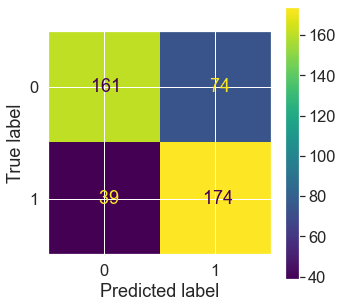

In [68]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgb,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [69]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.69      0.74       235
           1       0.70      0.82      0.75       213

    accuracy                           0.75       448
   macro avg       0.75      0.75      0.75       448
weighted avg       0.76      0.75      0.75       448



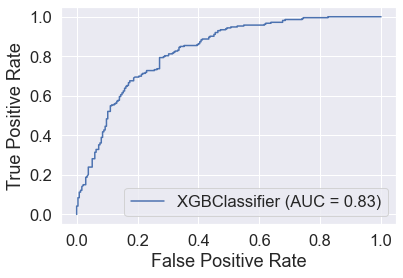

In [70]:
plot_roc_curve(xgb,X_test,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

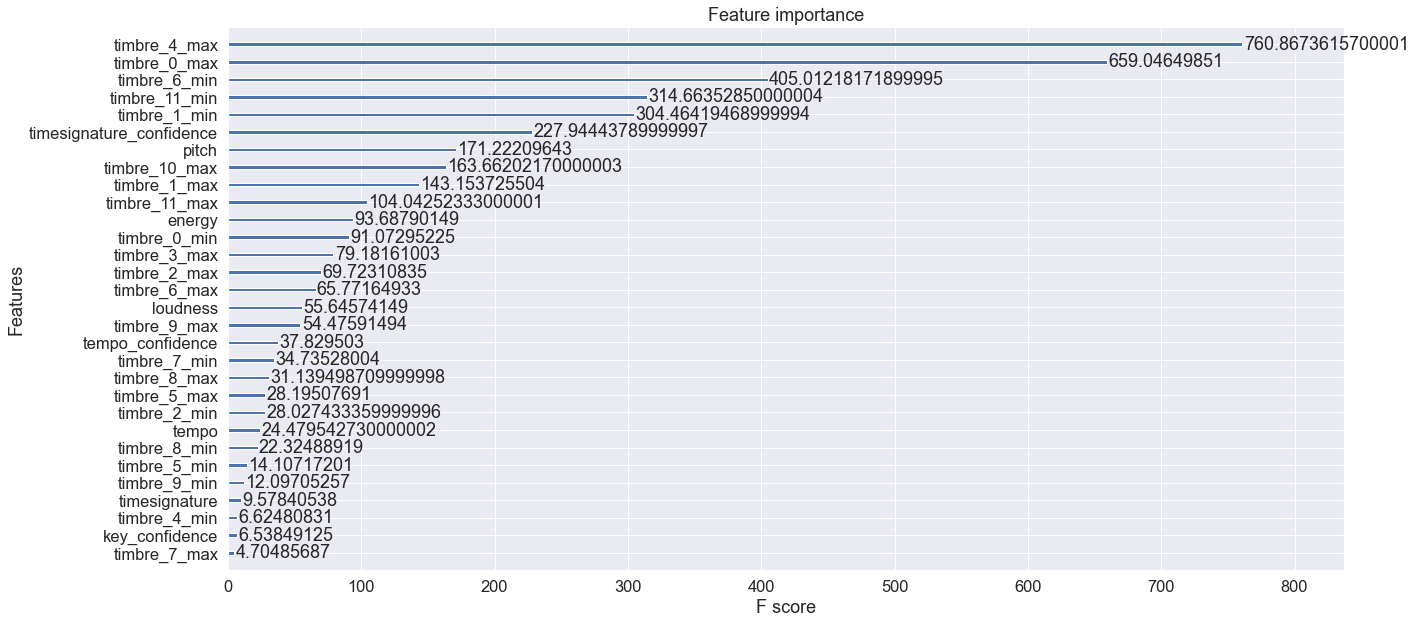

In [71]:
fig, ax = plt.subplots(figsize=(20,10))
plot_importance(xgb,ax=ax,importance_type='total_gain')
plt.show()

Example:

f = 'gain'

XGBClassifier.get_booster().get_score(importance_type= f)

### Cross-Validation

In [72]:
cv = cross_val_score(xgb,X,y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished


In [73]:
cv.mean()

0.7171460530520933

### Feature Selection

In [74]:
df3.columns

Index(['timesignature', 'timesignature_confidence', 'loudness', 'tempo',
       'tempo_confidence', 'key', 'key_confidence', 'energy', 'pitch',
       'timbre_0_min', 'timbre_0_max', 'timbre_1_min', 'timbre_1_max',
       'timbre_2_min', 'timbre_2_max', 'timbre_3_min', 'timbre_3_max',
       'timbre_4_min', 'timbre_4_max', 'timbre_5_min', 'timbre_5_max',
       'timbre_6_min', 'timbre_6_max', 'timbre_7_min', 'timbre_7_max',
       'timbre_8_min', 'timbre_8_max', 'timbre_9_min', 'timbre_9_max',
       'timbre_10_min', 'timbre_10_max', 'timbre_11_min', 'timbre_11_max',
       'Top10'],
      dtype='object')

In [75]:
df4 = df3[['timbre_4_max','timbre_0_max','timbre_6_min','timbre_11_min','pitch','timbre_1_min','timesignature_confidence','Top10']]

In [76]:
df4

,timbre_4_max,timbre_0_max,timbre_6_min,timbre_11_min,pitch,timbre_1_min,timesignature_confidence,Top10
0,0.255969,0.797409,0.802216,0.887599,0.012939,0.349646,0.722,0
1,0.493794,0.842972,0.304231,0.596866,0.005545,0.431774,1.000,0
2,0.442074,0.849328,0.563977,0.674654,0.003697,0.682314,1.000,0
3,0.071265,0.897474,0.624682,0.796949,0.072089,0.784897,0.516,0
4,0.515777,0.871948,0.401820,0.614369,0.035120,0.642431,1.000,0
...,...,...,...,...,...,...,...,...
2233,0.513339,0.817951,0.377532,0.773230,0.011091,0.664069,1.000,1
2234,0.453969,0.794645,0.363520,0.563994,0.001848,0.340312,0.326,1
2235,0.466038,0.918237,0.506943,0.730827,0.042514,0.688664,0.712,1
2236,0.641213,0.828726,0.365548,0.706185,0.029575,0.390823,1.000,1


In [77]:
X = df4.iloc[:,0:7]
y = df4.iloc[:,7]

In [78]:
X.values, y.values

(array([[0.25596857, 0.7974091 , 0.80221593, ..., 0.012939  , 0.34964641,
         0.722     ],
        [0.49379382, 0.84297187, 0.30423101, ..., 0.00554529, 0.43177352,
         1.        ],
        [0.44207406, 0.84932806, 0.56397723, ..., 0.00369686, 0.68231363,
         1.        ],
        ...,
        [0.46603774, 0.91823722, 0.50694306, ..., 0.04251386, 0.68866389,
         0.712     ],
        [0.64121301, 0.82872594, 0.36554806, ..., 0.02957486, 0.3908232 ,
         1.        ],
        [0.47306263, 0.9197506 , 0.30228243, ..., 0.01109057, 0.47672495,
         0.973     ]]),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int64))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [80]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1790, 7), (448, 7), (1790,), (448,))

In [81]:
xgb2 = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [82]:
xgb2.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.316964
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.330357
[2]	validation_0-error:0.321429
[3]	validation_0-error:0.330357
[4]	validation_0-error:0.305804
[5]	validation_0-error:0.305804
[6]	validation_0-error:0.294643
[7]	validation_0-error:0.292411
[8]	validation_0-error:0.287946
[9]	validation_0-error:0.287946
[10]	validation_0-error:0.292411
[11]	validation_0-error:0.283482
[12]	validation_0-error:0.296875
[13]	validation_0-error:0.283482
[14]	validation_0-error:0.28125
[15]	validation_0-error:0.28125
[16]	validation_0-error:0.279018
[17]	validation_0-error:0.28125
[18]	validation_0-error:0.285714
[19]	validation_0-error:0.28125
[20]	validation_0-error:0.283482
[21]	validation_0-error:0.285714
[22]	validation_0-error:0.279018
[23]	validation_0-error:0.279018
[24]	validation_0-error:0.279018
[25]	validation_0-error:0.276786
[26]	validation_0-error:0.276786
[27]	validation_0-error:0.276786
[28]	validation_0-error:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [83]:
y_pred = xgb2.predict(X_test)

In [84]:
y_pred

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,

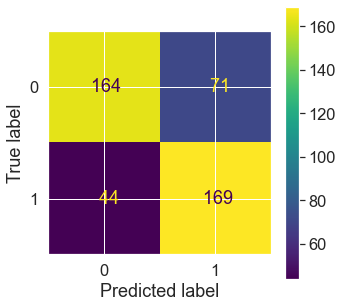

In [85]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgb2,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [86]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74       235
           1       0.70      0.79      0.75       213

    accuracy                           0.74       448
   macro avg       0.75      0.75      0.74       448
weighted avg       0.75      0.74      0.74       448



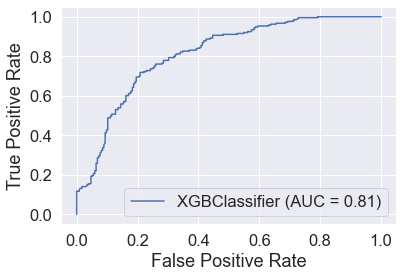

In [87]:
plot_roc_curve(xgb2,X_test,y_test)
plt.show()

#### Note: Accuracy dropped a bit

### Model Tuning

In [88]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [89]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [90]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, n_jobs=-1,
                           scoring='accuracy')

In [91]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [92]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=8,
              learning rate=0.08, learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=3, missing=None, n_estimators=300,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7, verbosity=1)

In [93]:
randm.best_score_

0.718485338766379

In [94]:
randm.best_params_

{'subsample': 0.7,
 'n_estimators': 300,
 'min_child_weight': 3,
 'max_depth': 6,
 'learning rate': 0.08,
 'gamma': 8,
 'colsample_bytree': 0.7}

### Load the previous one

In [95]:
X = df3.iloc[:,0:33]
y = df3.iloc[:,33]

In [96]:
randm.fit(X, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [97]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=6,
              learning rate=0.2, learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=3, missing=None, n_estimators=700,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.6, verbosity=1)

In [98]:
randm.best_score_

0.7269704777884308

In [99]:
randm.best_params_

{'subsample': 0.6,
 'n_estimators': 700,
 'min_child_weight': 3,
 'max_depth': 7,
 'learning rate': 0.2,
 'gamma': 6,
 'colsample_bytree': 0.7999999999999999}

### Final Model

In [100]:
xgbnew = XGBClassifier(random_state=0, n_estimators=700, objective='binary:logistic',max_depth=7,
                      gamma=6, min_child_weight=3,subsample=0.6,learning_rate=0.2,colsample_bytree=0.8)

In [101]:
xgbnew.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.337054
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.28125
[2]	validation_0-error:0.272321
[3]	validation_0-error:0.265625
[4]	validation_0-error:0.265625
[5]	validation_0-error:0.263393
[6]	validation_0-error:0.261161
[7]	validation_0-error:0.256696
[8]	validation_0-error:0.274554
[9]	validation_0-error:0.25
[10]	validation_0-error:0.25
[11]	validation_0-error:0.256696
[12]	validation_0-error:0.258929
[13]	validation_0-error:0.25
[14]	validation_0-error:0.247768
[15]	validation_0-error:0.241071
[16]	validation_0-error:0.234375
[17]	validation_0-error:0.238839
[18]	validation_0-error:0.236607
[19]	validation_0-error:0.247768
[20]	validation_0-error:0.25
[21]	validation_0-error:0.25
[22]	validation_0-error:0.254464
[23]	validation_0-error:0.252232
[24]	validation_0-error:0.247768
[25]	validation_0-error:0.247768
[26]	validation_0-error:0.252232
Stopping. Best iteration:
[16]	validation_0-error:0.234375



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=6,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=3, missing=None, n_estimators=700, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [102]:
y_pred = xgbnew.predict(X_test)

In [103]:
y_pred

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,

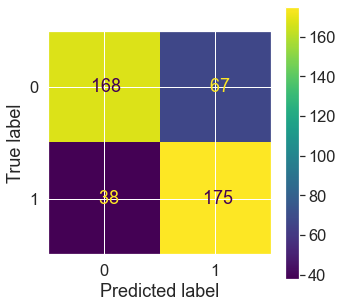

In [104]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbnew,X_test,y_test,values_format='4g',ax=ax)
plt.show()

In [105]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76       235
           1       0.72      0.82      0.77       213

    accuracy                           0.77       448
   macro avg       0.77      0.77      0.77       448
weighted avg       0.77      0.77      0.77       448



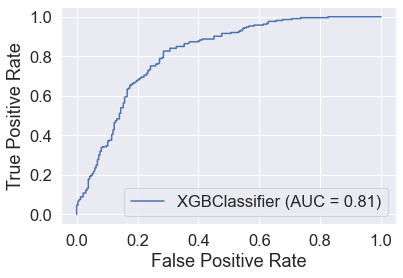

In [106]:
plot_roc_curve(xgbnew,X_test,y_test)
plt.show()